In [1]:
#scan.ipynb
#by Joe Hahn, jmh.datasciences@gmail.com, 2 August 2020.
#inspect the output of all simulations launched by scan.py

In [2]:
#get paths to all simulations
import os
parent_path = 'permutations/'
paths = os.listdir(parent_path)
paths.remove('.gitignore')
paths = [parent_path + path for path in paths]
print 'number of paths = ', len(paths)
paths[0:5]

number of paths =  231


['permutations/total_ring_mass=1.0000000000000007e-09_radial_width=0.0005_shear_viscosity=3.9810717055349773e-13_sim_id=109_timesteps_per_output=4144_',
 'permutations/total_ring_mass=9.999999999999982e-09_radial_width=0.0005_shear_viscosity=3.1622776601683786e-12_sim_id=220_timesteps_per_output=5217_',
 'permutations/total_ring_mass=3.9810717055349665e-09_radial_width=0.0005_shear_viscosity=1.9952623149688807e-13_sim_id=170_timesteps_per_output=32921_',
 'permutations/total_ring_mass=1.5848931924611155e-10_radial_width=0.0005_shear_viscosity=7.94328234724283e-13_sim_id=27_timesteps_per_output=329_',
 'permutations/total_ring_mass=1.5848931924611115e-09_radial_width=0.0005_shear_viscosity=7.94328234724283e-13_sim_id=132_timesteps_per_output=3292_']

In [3]:
#prep plots
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.max_open_warning': 0})
color_seq = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
#order paths by sim_id
data = []
for p in paths:
    str_id = int(p.split('sim_id=')[1].split('_timesteps_per_output=')[0])
    d = {'sim_id':str_id, 'path':p}
    data += [d]
paths_df = pd.DataFrame(data)[['sim_id', 'path']].sort_values('sim_id').reset_index(drop=True)
paths_df.head()

sim_id                                               path
0       0  permutations/total_ring_mass=9.999999999999996...
1       1  permutations/total_ring_mass=9.999999999999996...
2       2  permutations/total_ring_mass=9.999999999999996...
3       3  permutations/total_ring_mass=9.999999999999996...
4       4  permutations/total_ring_mass=9.999999999999996...

In [5]:
#set power laws for ringlet's dynamical timescale = time for e_prime to reach 0.6, which is assumed to vary as 
#(ringlet_mass**mass_power_law)*(viscosity**viscosity_power_law)*(radial_width**width_power_law)
nominal_dynamical_timescale = 1.65e4
mass_power_law = 1.0
viscosity_power_law = -1.0
width_power_law = -0.33

helper_fns.py:29: RuntimeWarning: invalid value encountered in greater
  idx = angle > np.pi
helper_fns.py:31: RuntimeWarning: invalid value encountered in less
  idx = angle < -np.pi
libration.py:56: RuntimeWarning: invalid value encountered in greater
  idx = (dwt > np.pi)
libration.py:58: RuntimeWarning: invalid value encountered in less
  idx = (dwt < -np.pi)
libration.py:68: RuntimeWarning: invalid value encountered in sqrt
  q_factor = np.sqrt(1 - q2)


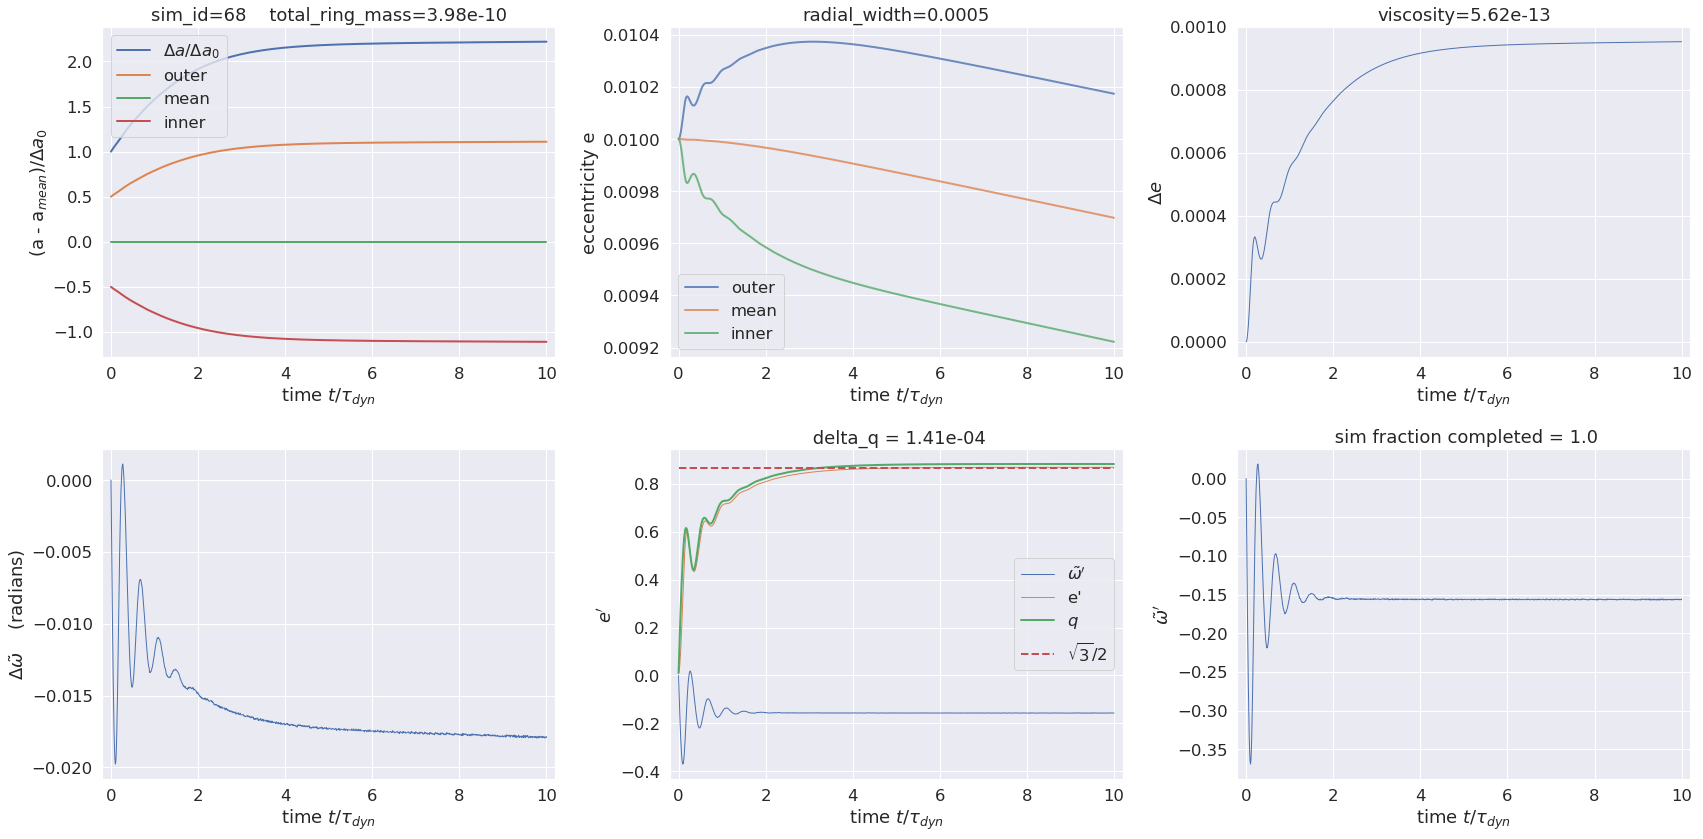

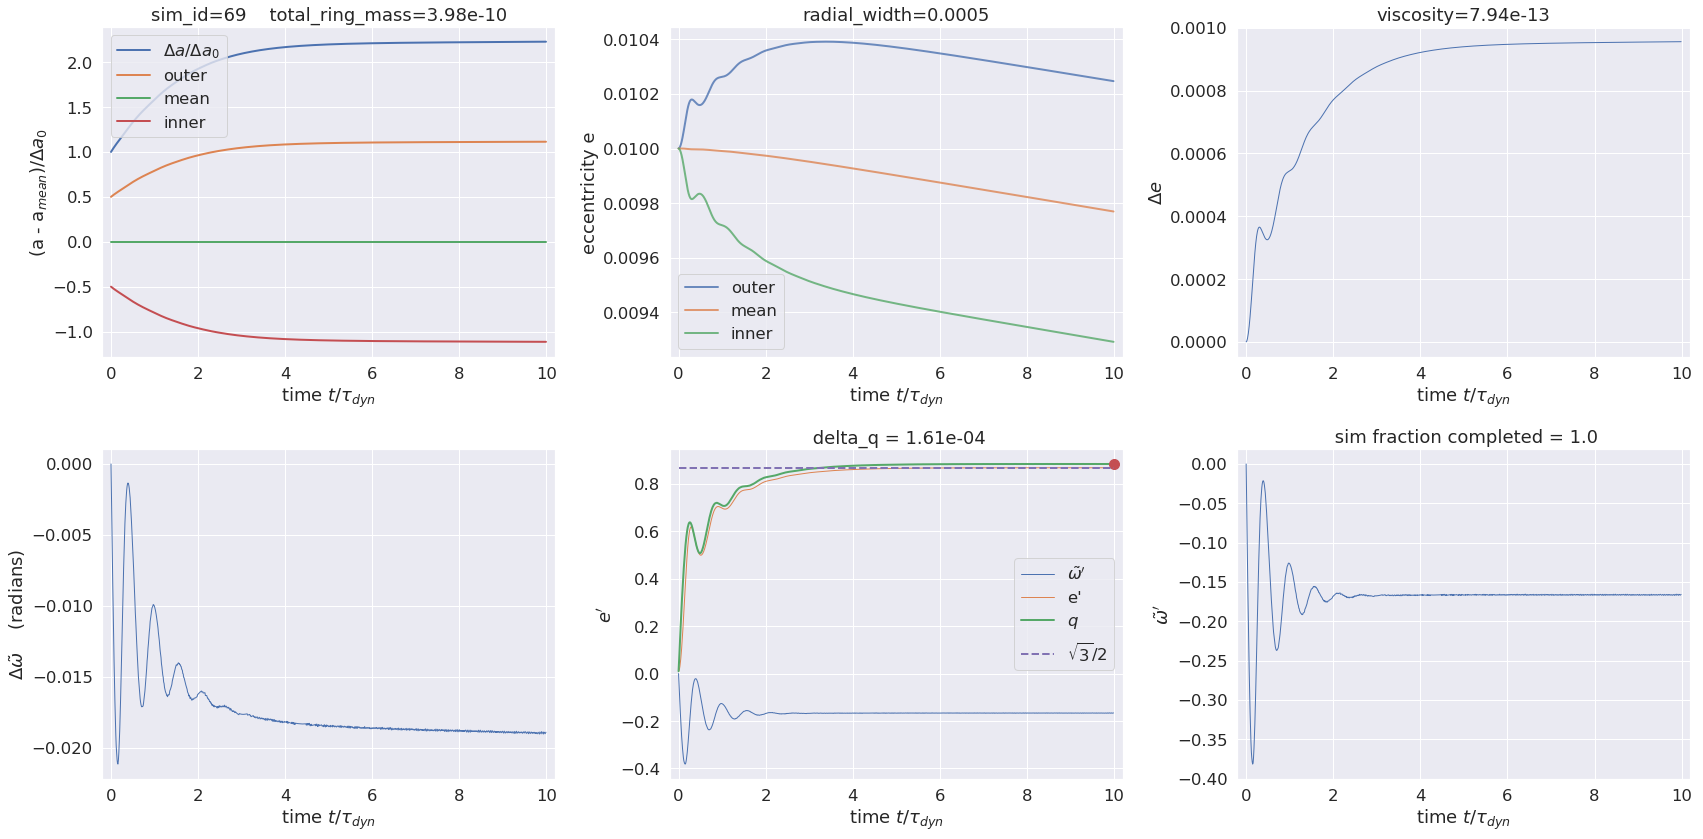

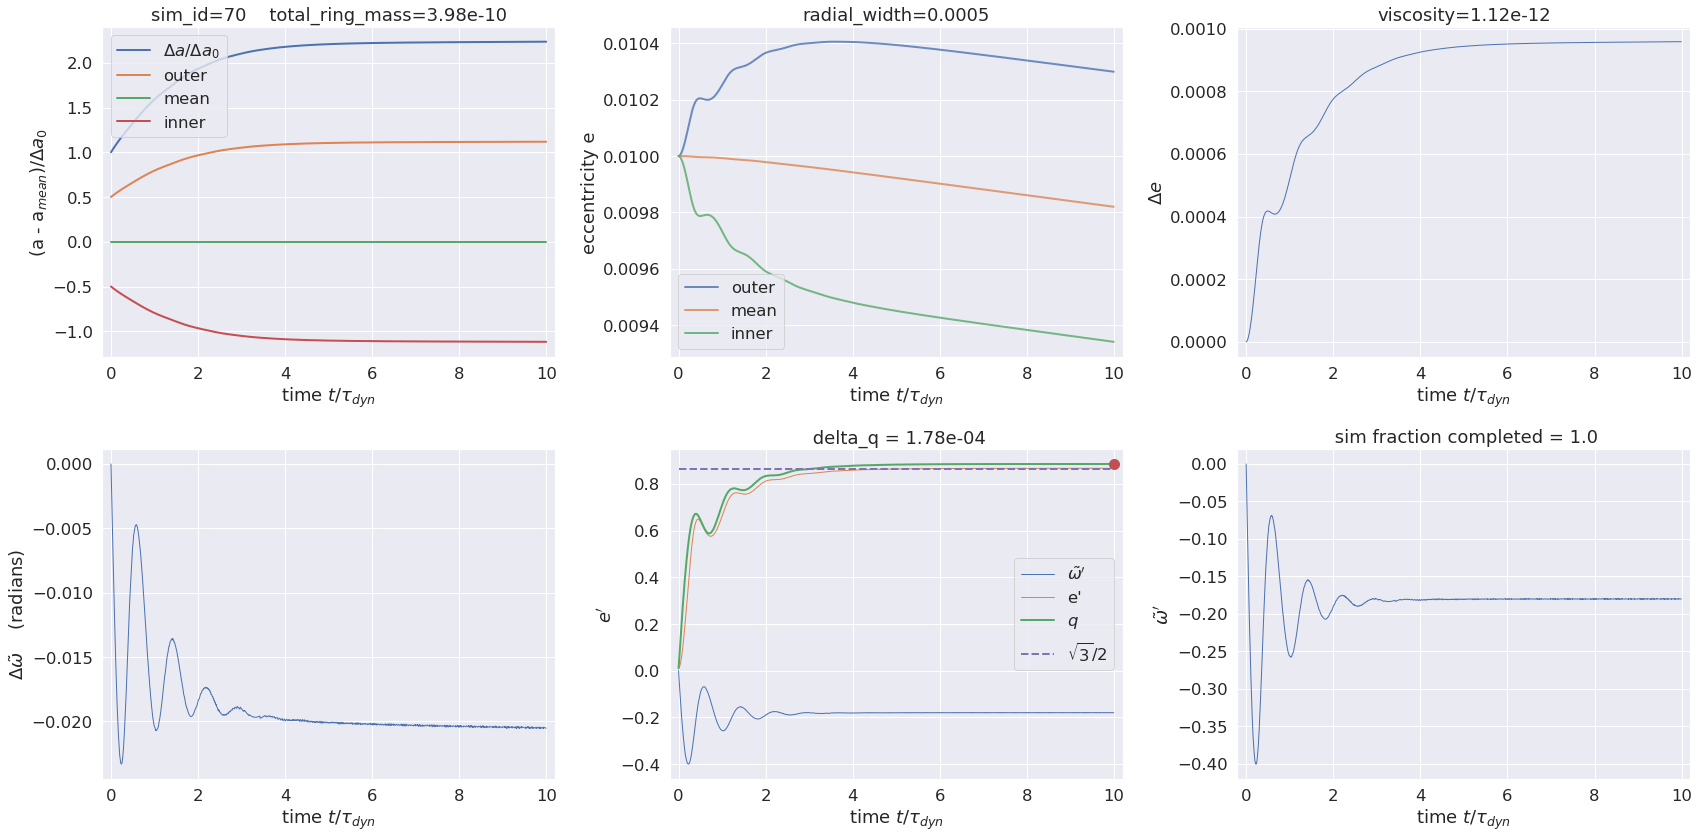

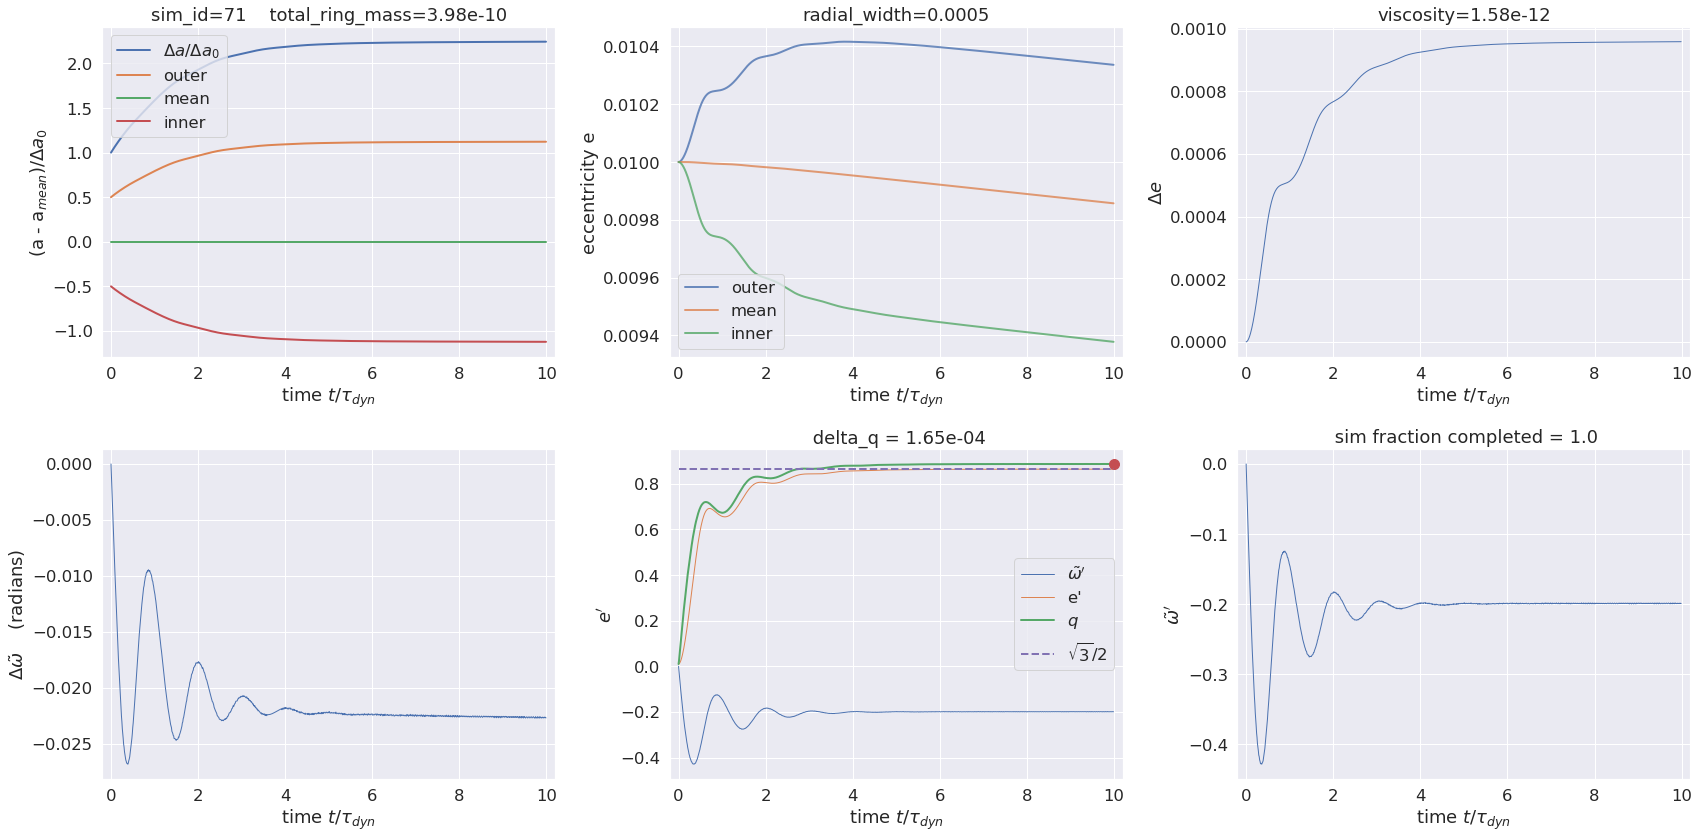

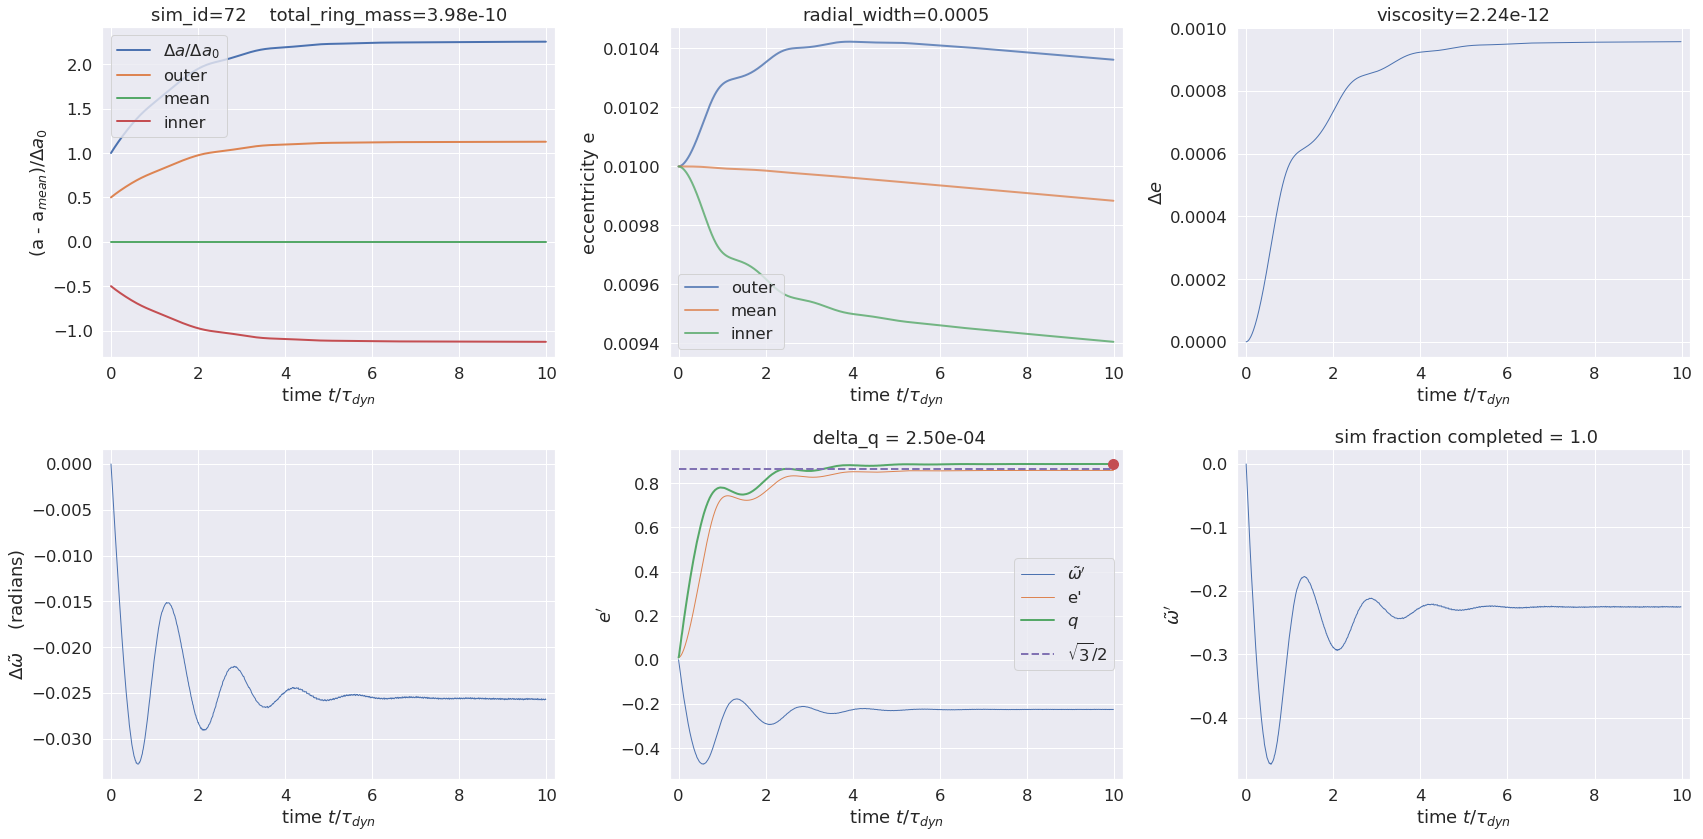

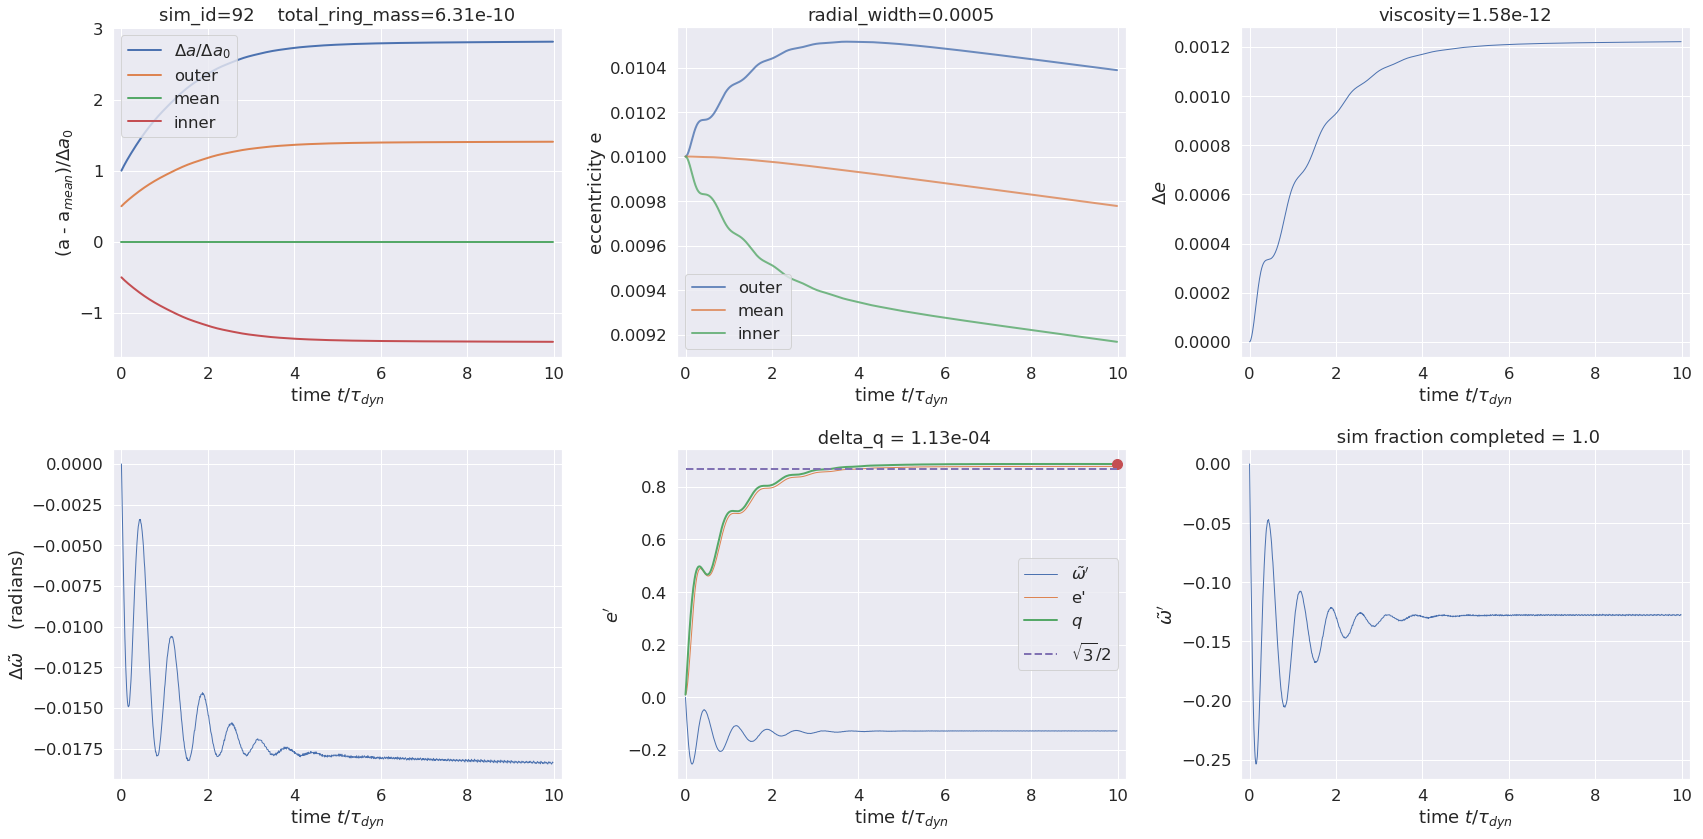

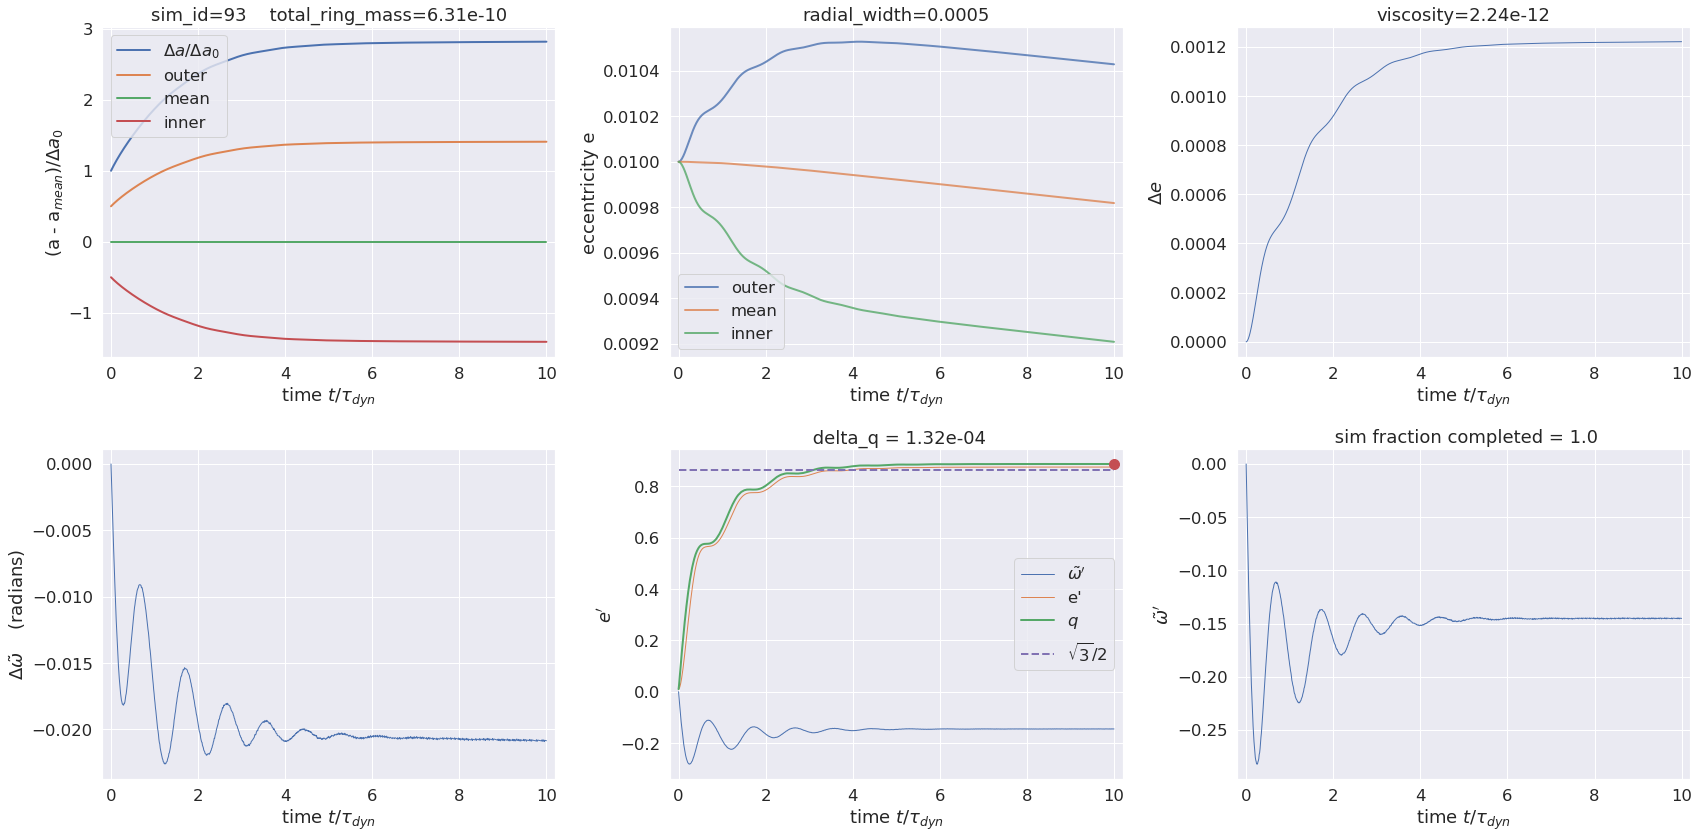

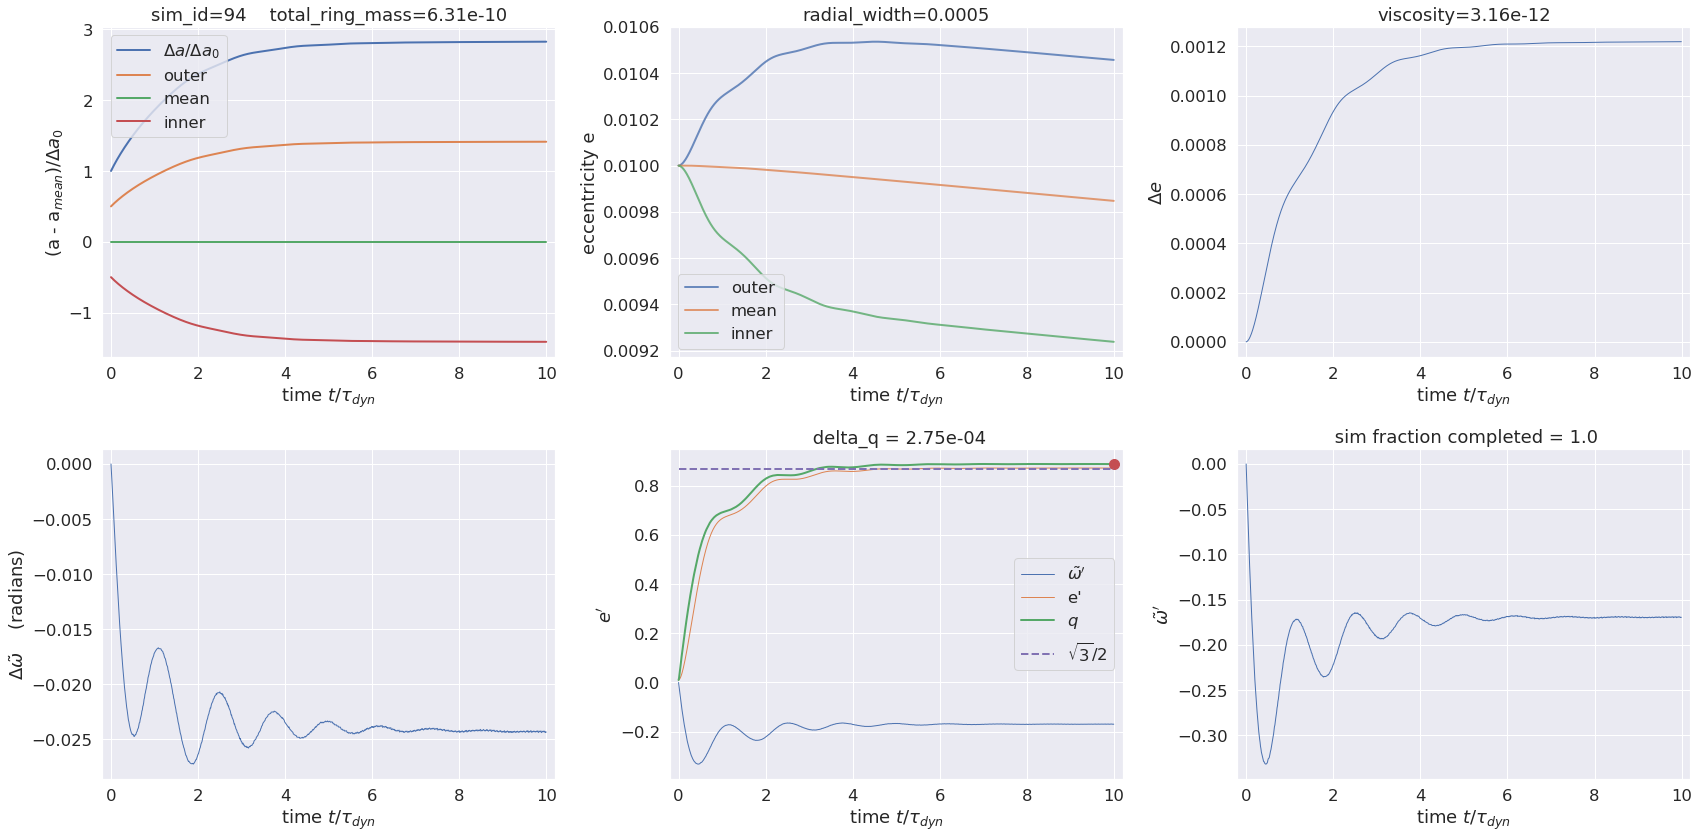

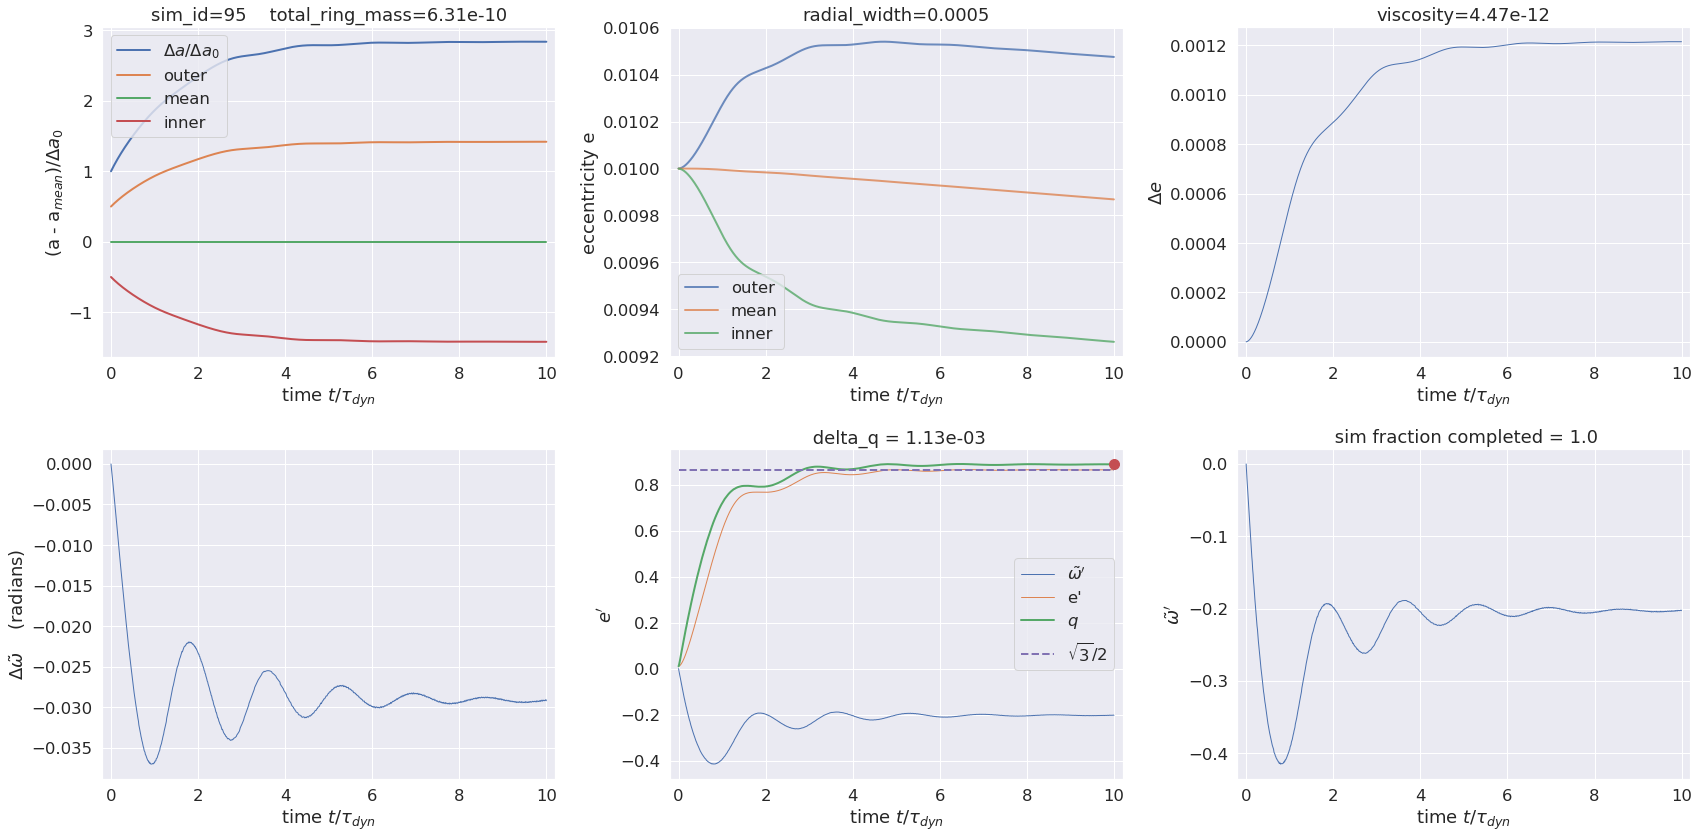

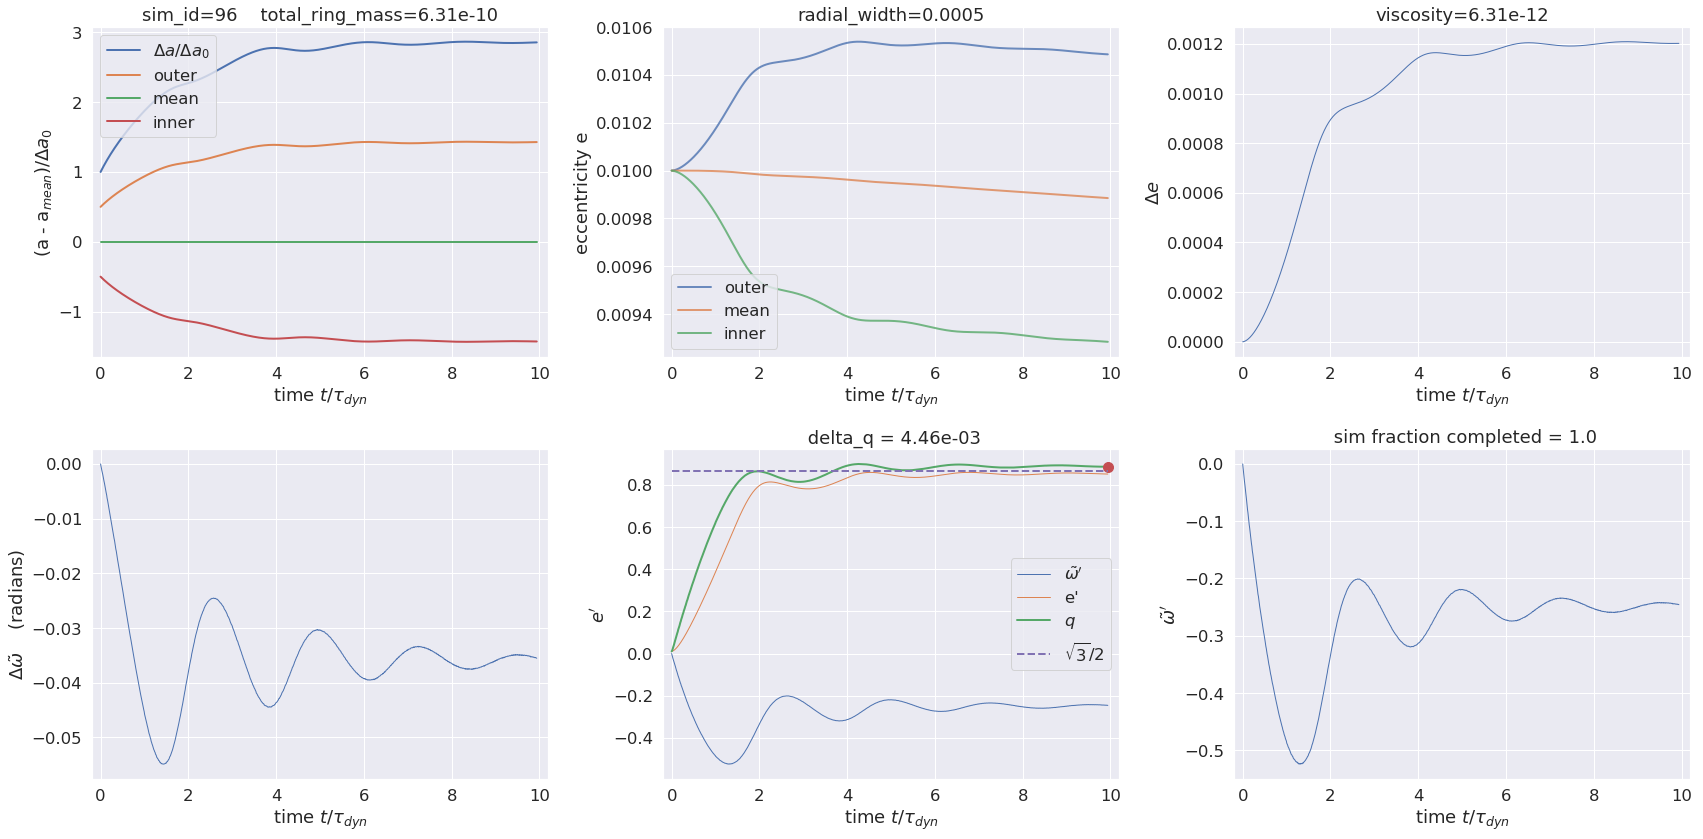

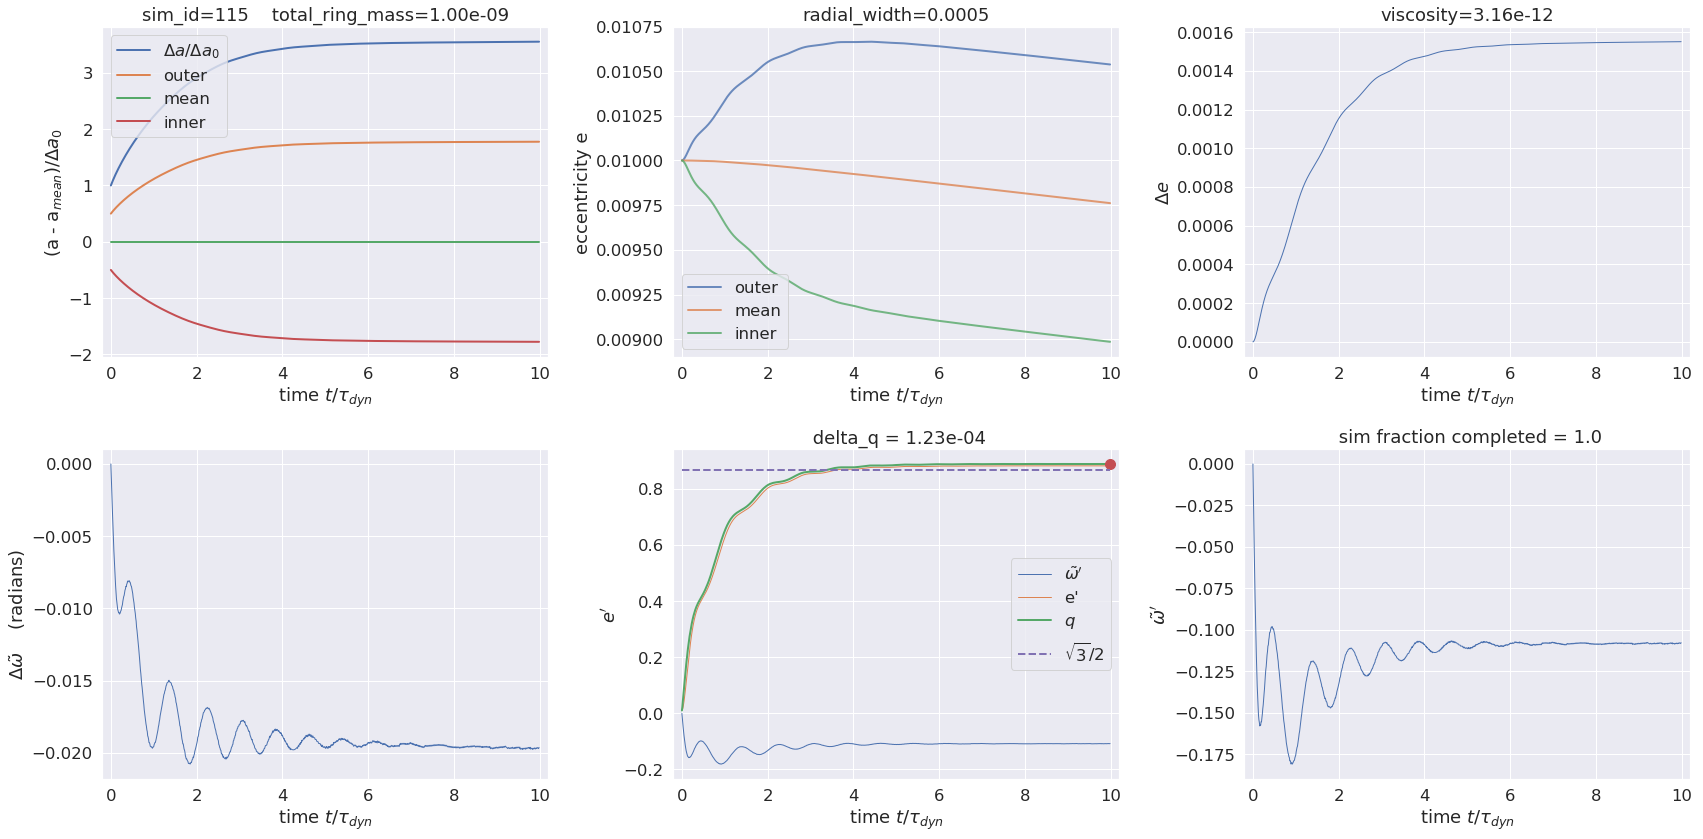

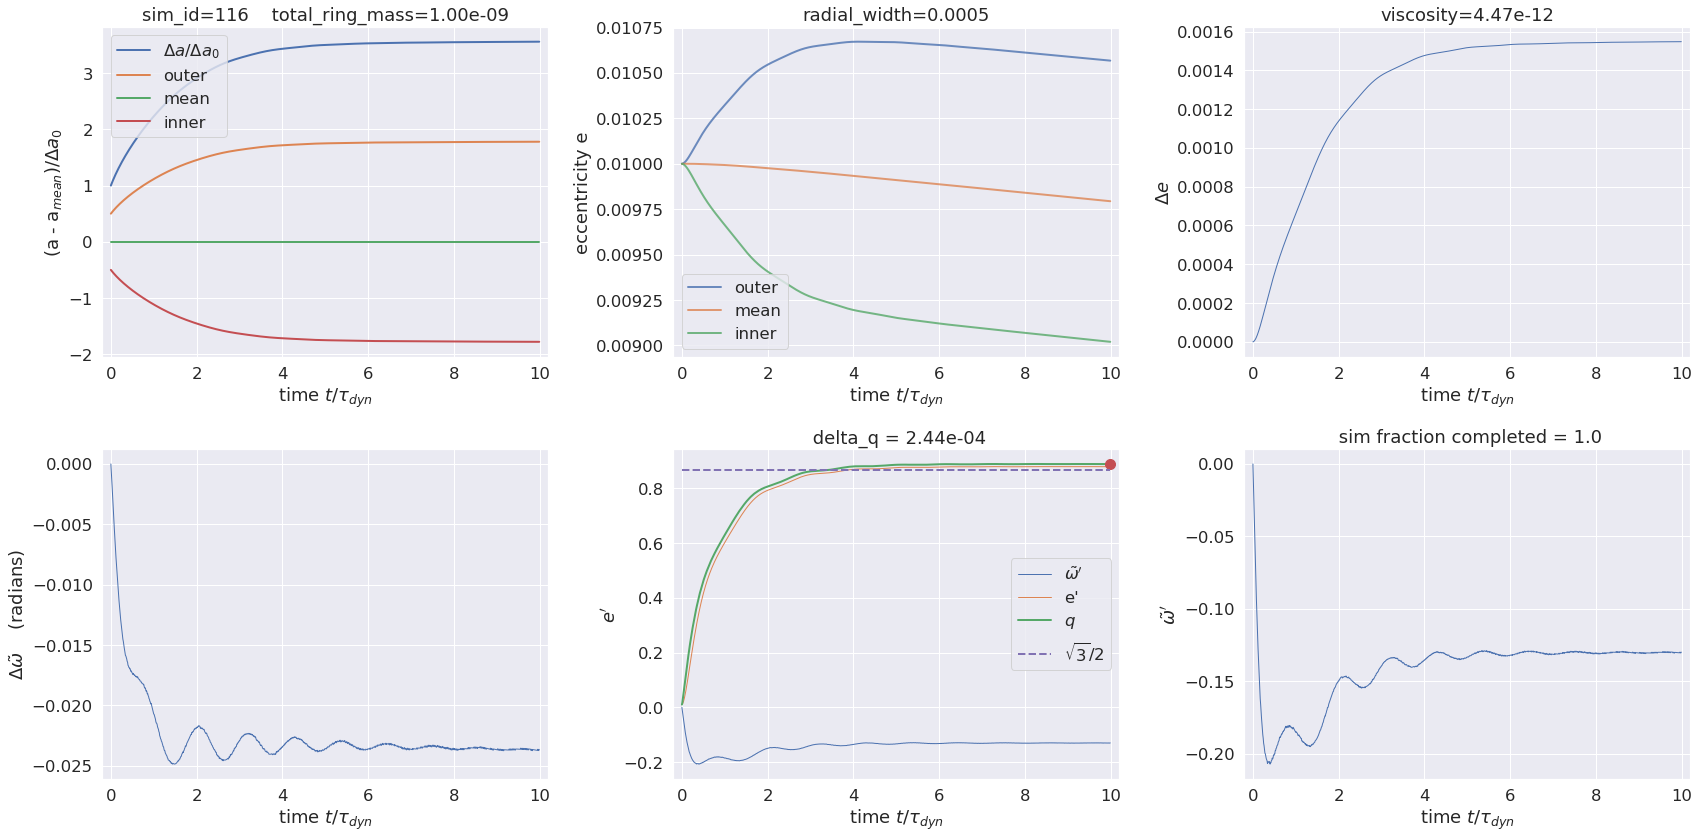

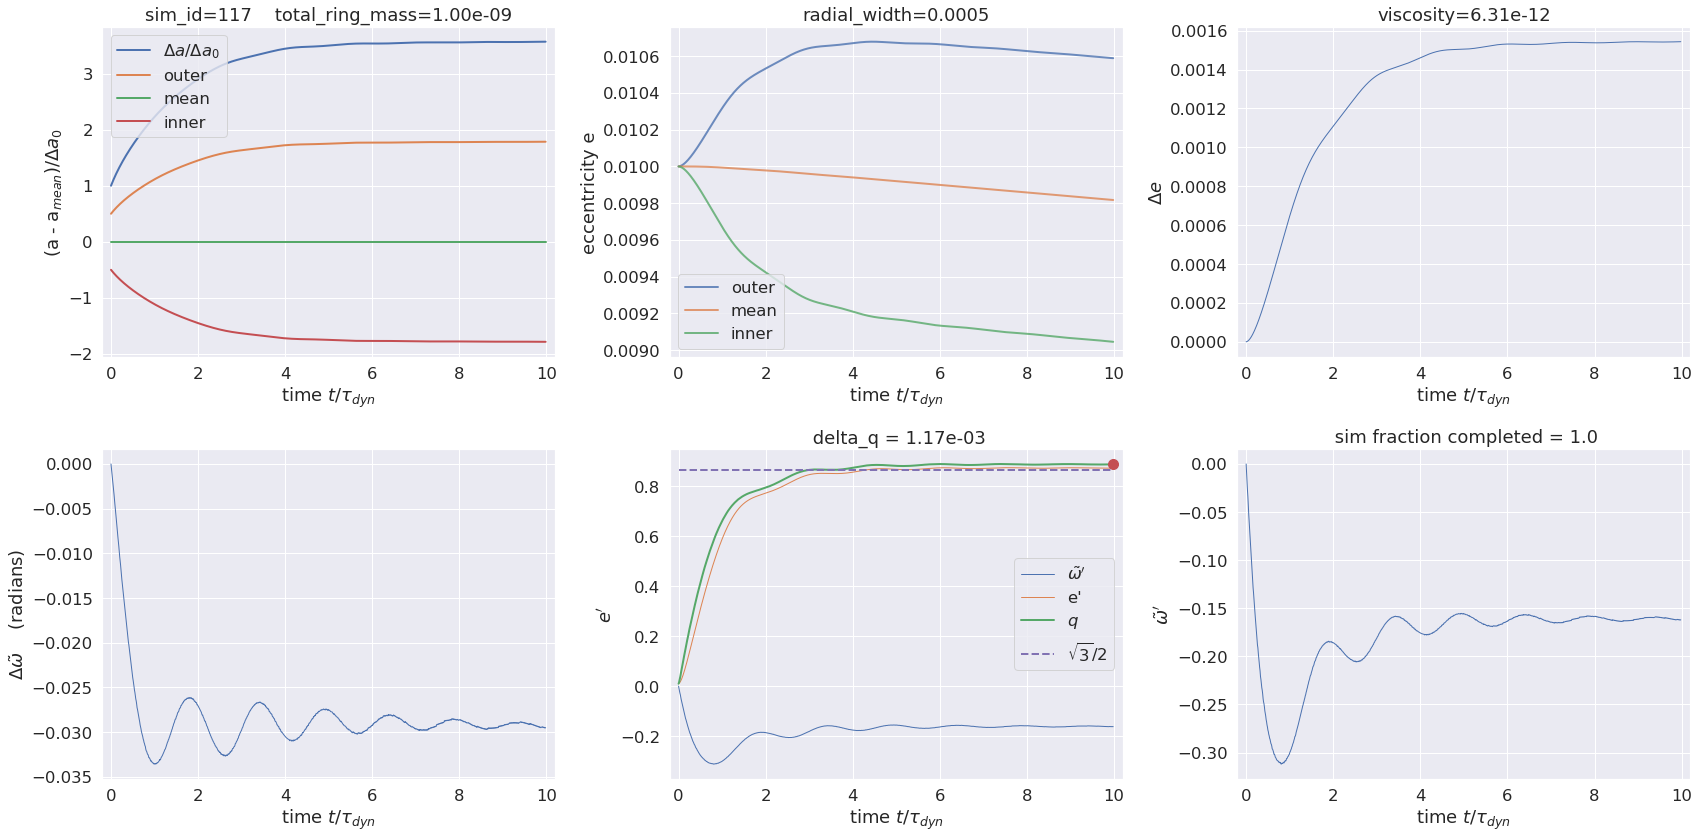

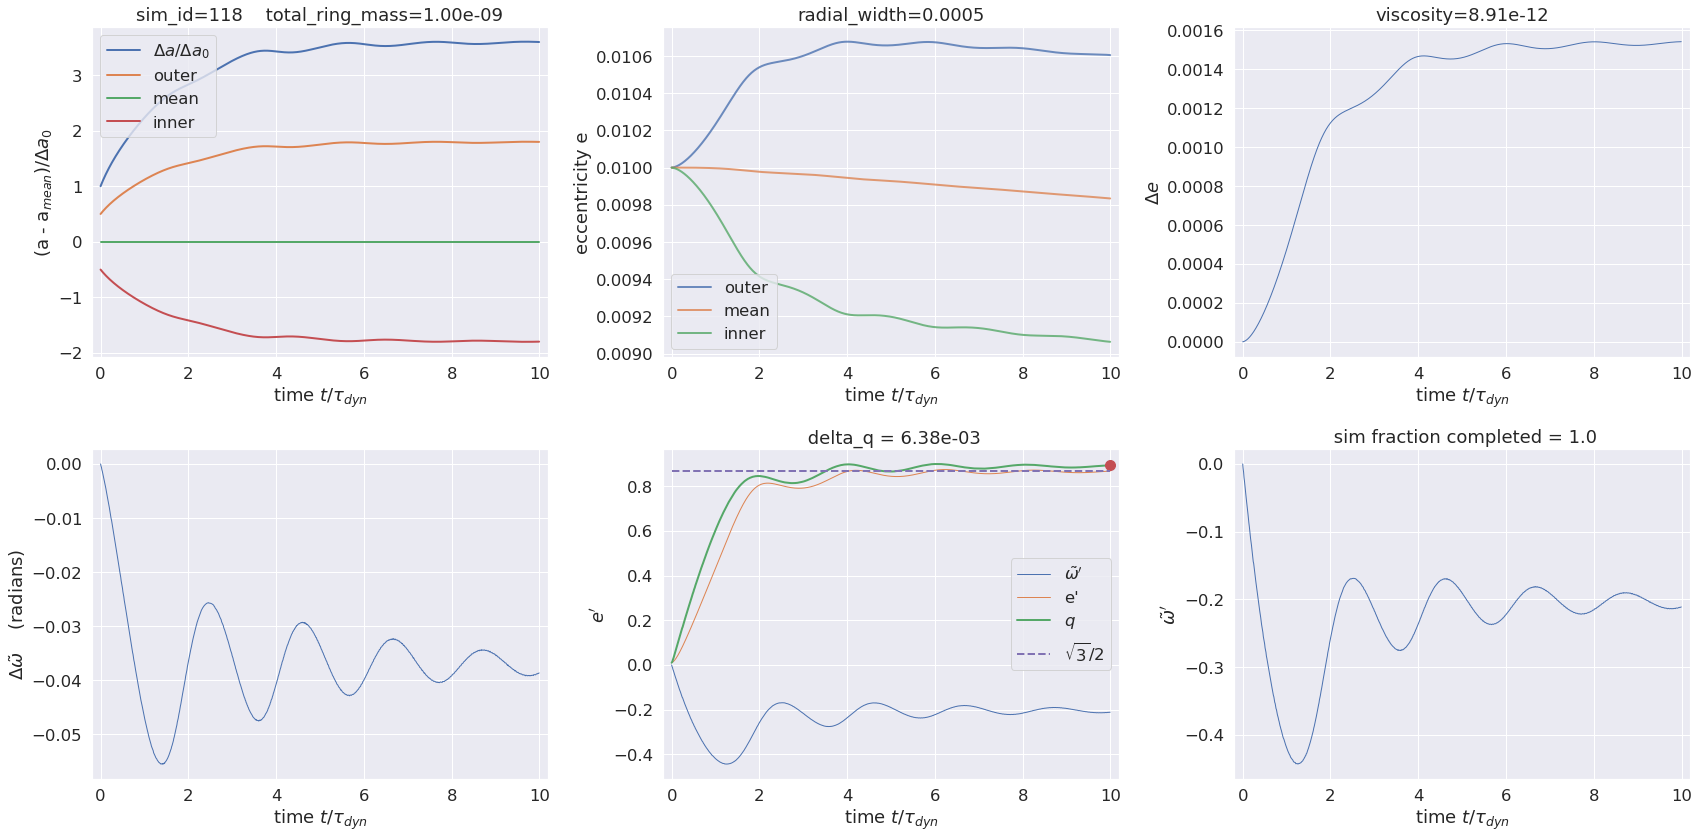

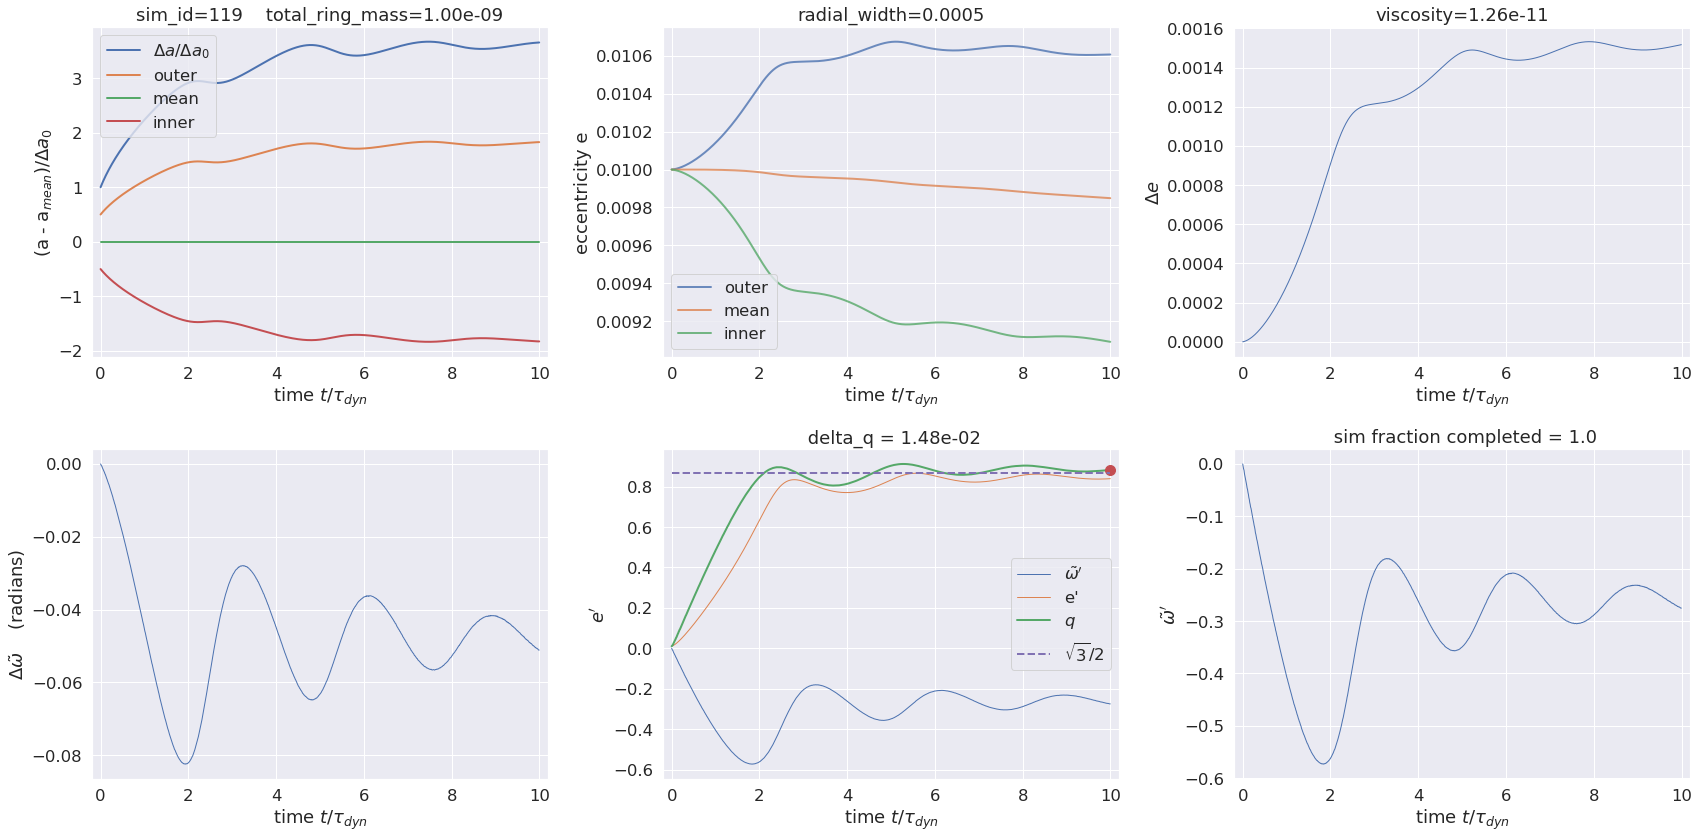

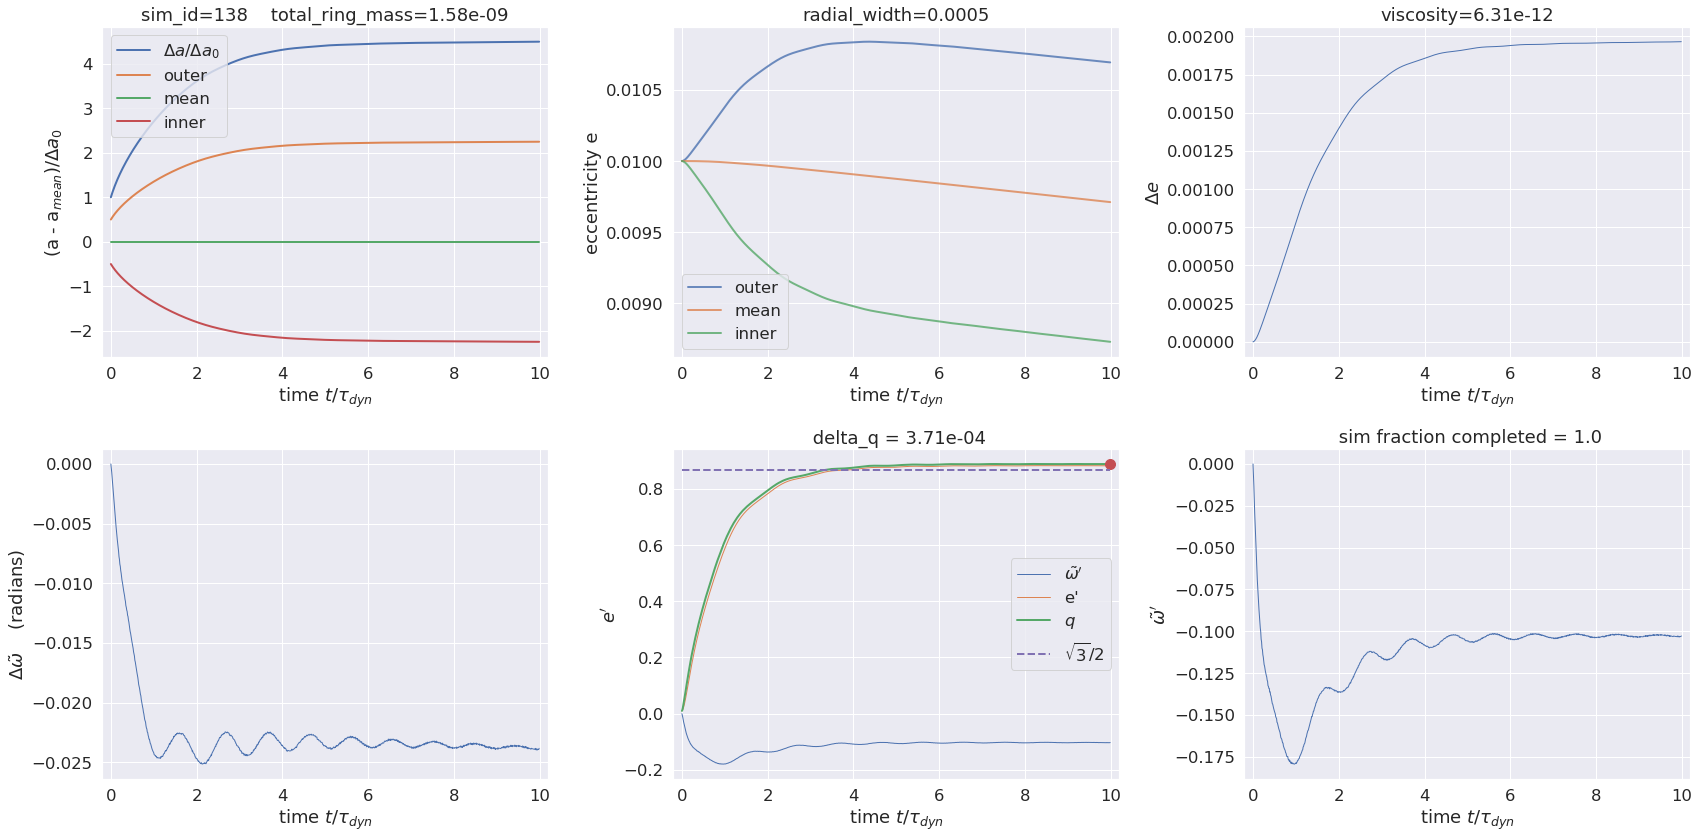

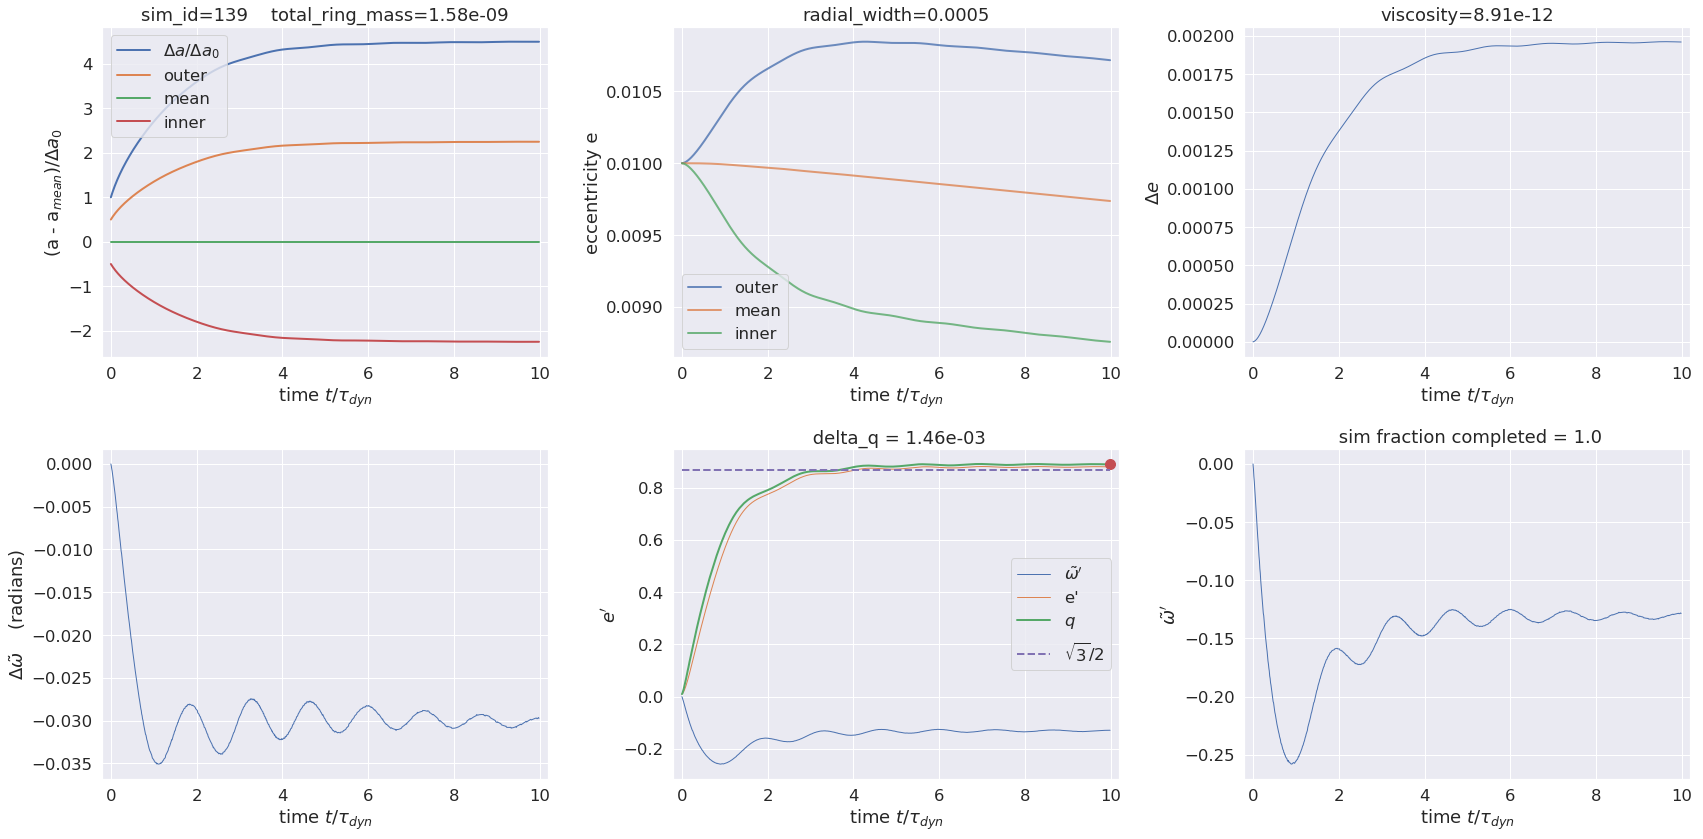

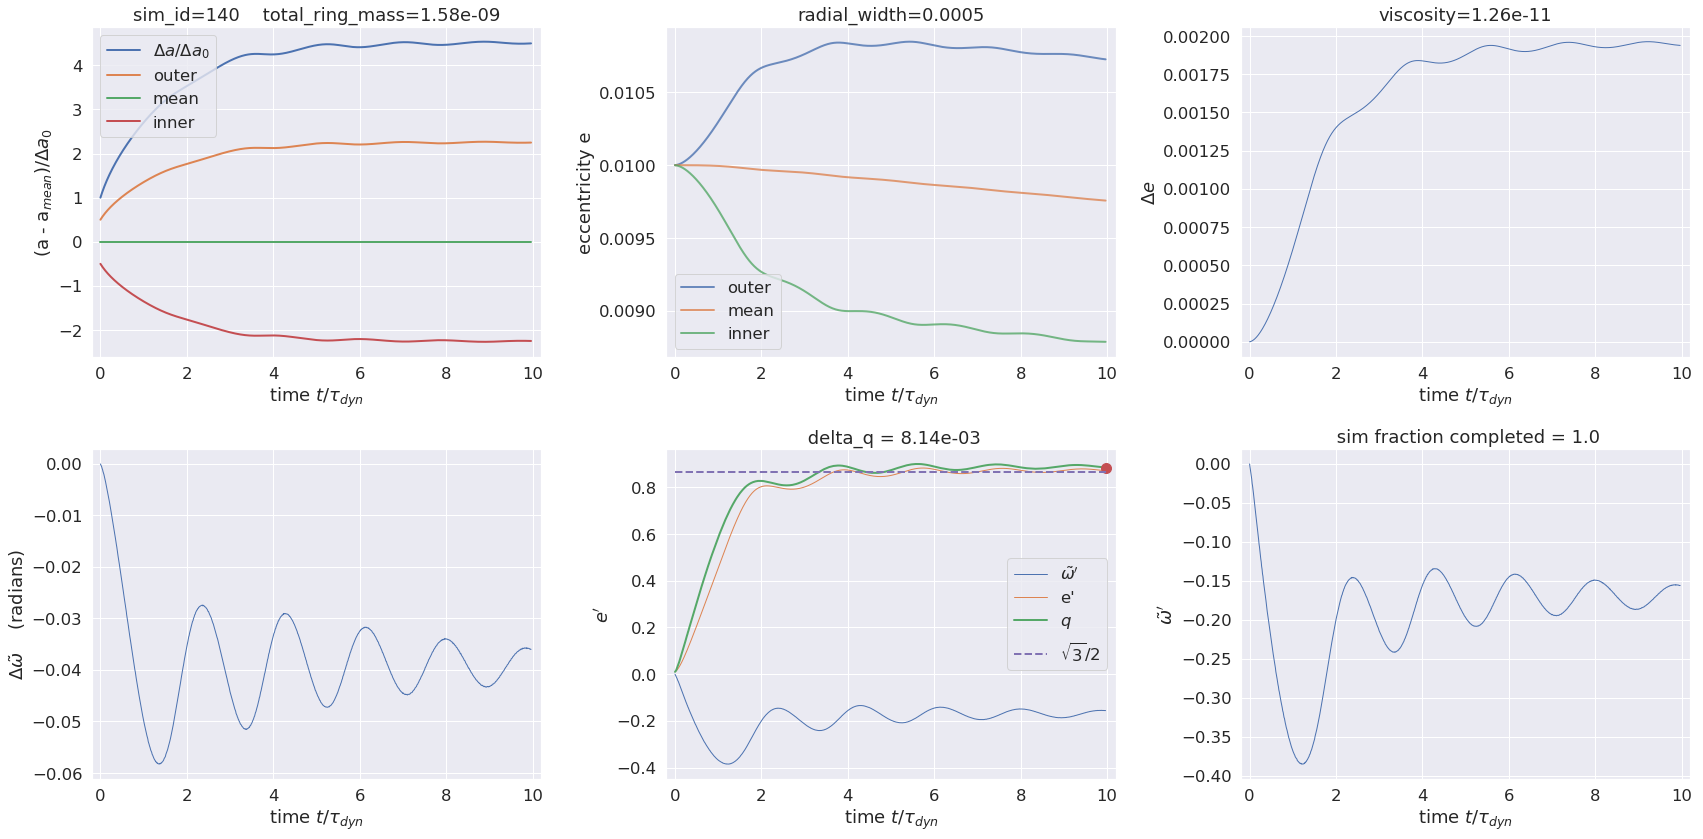

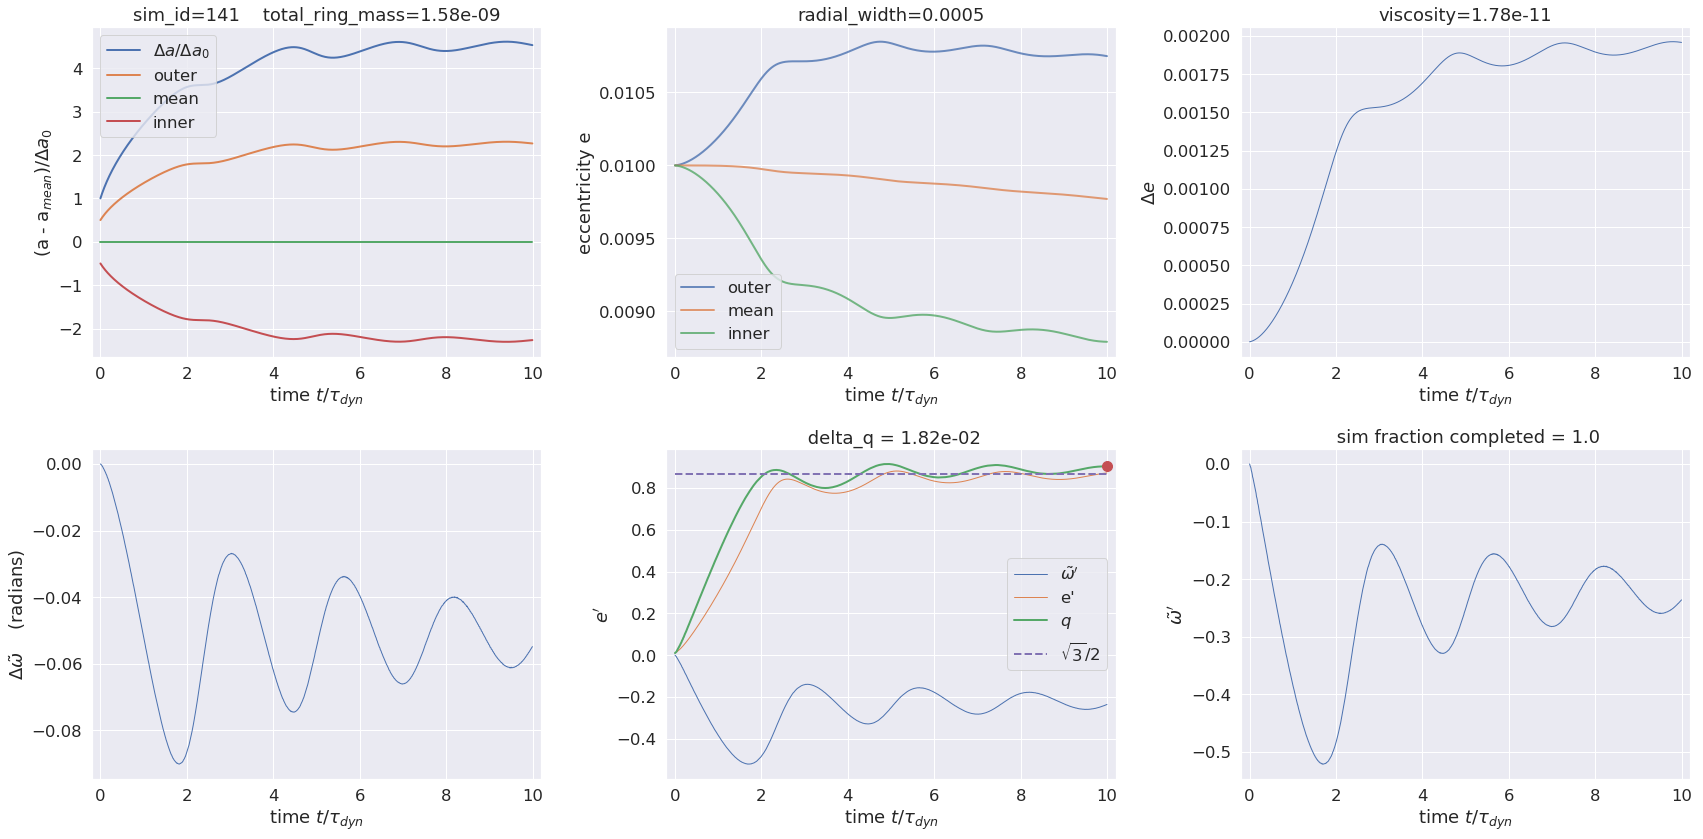

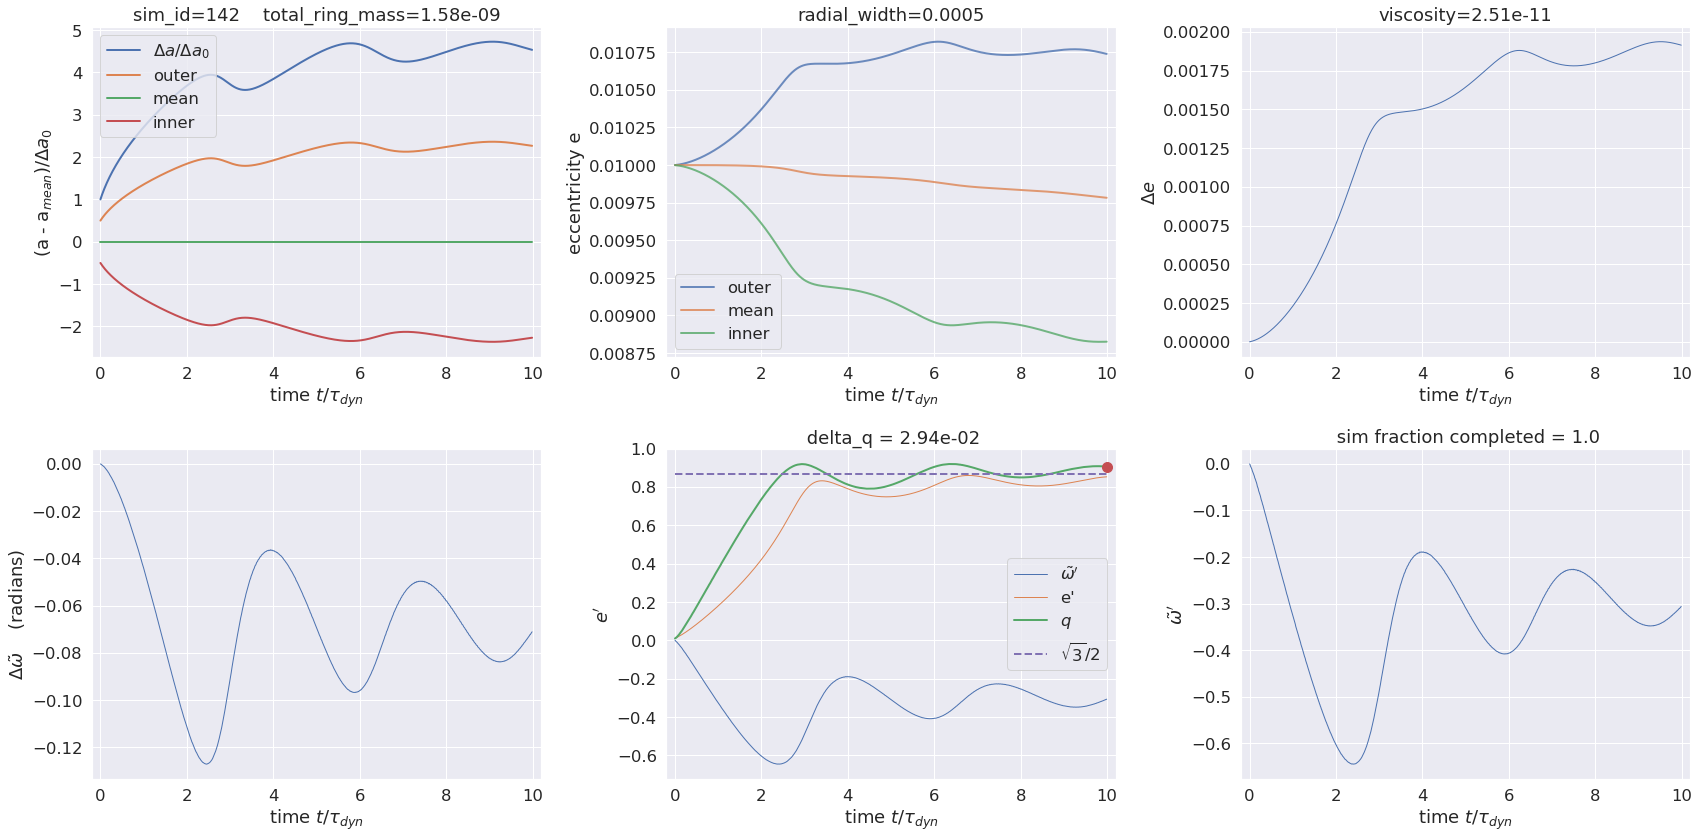

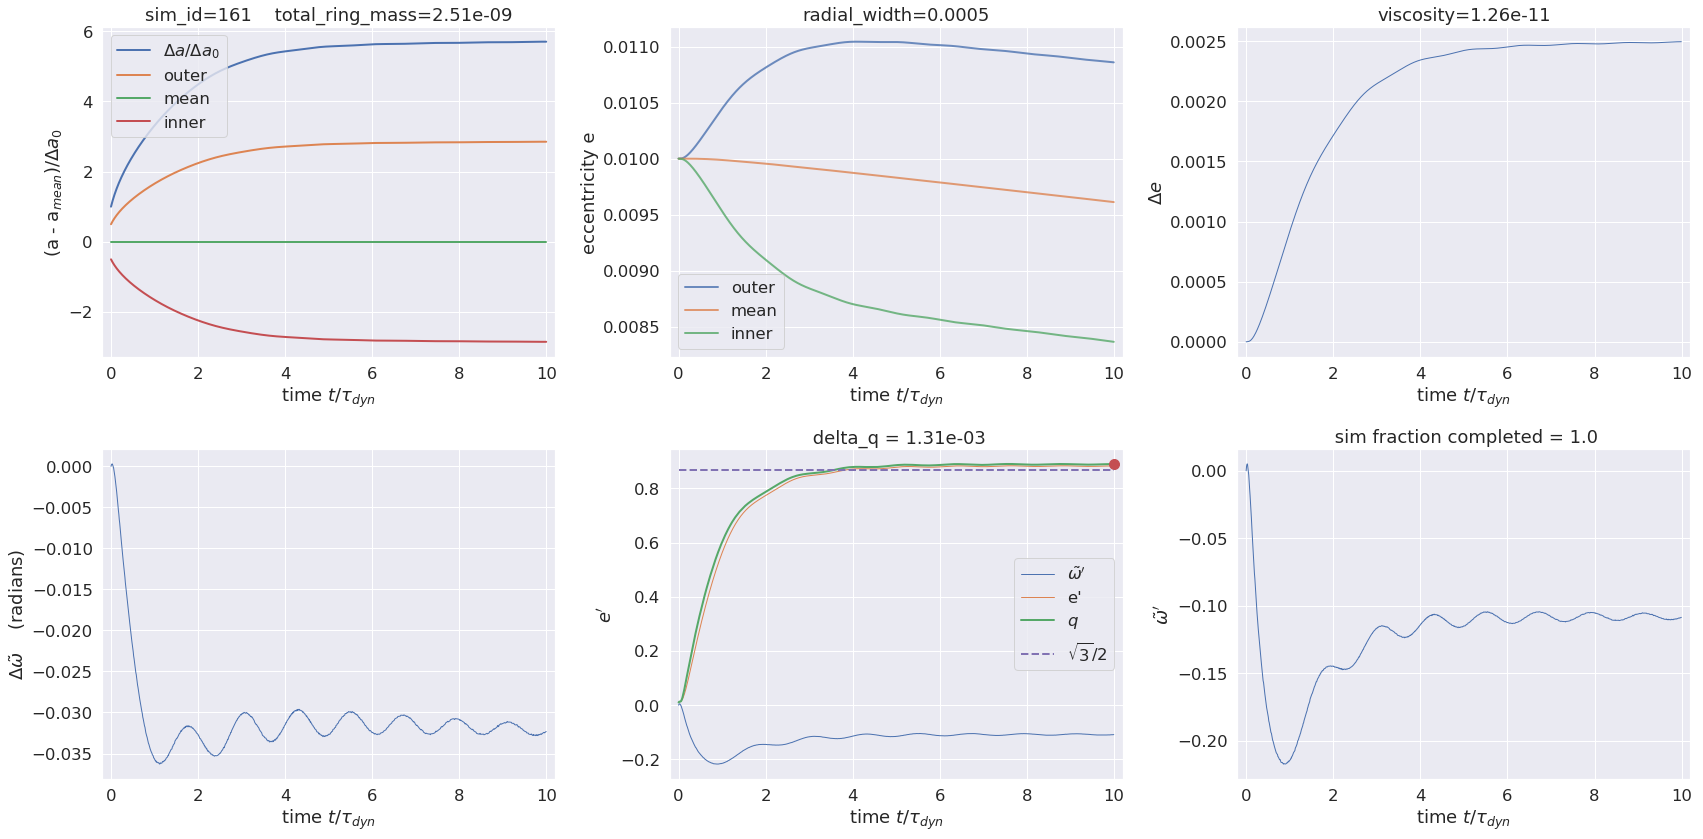

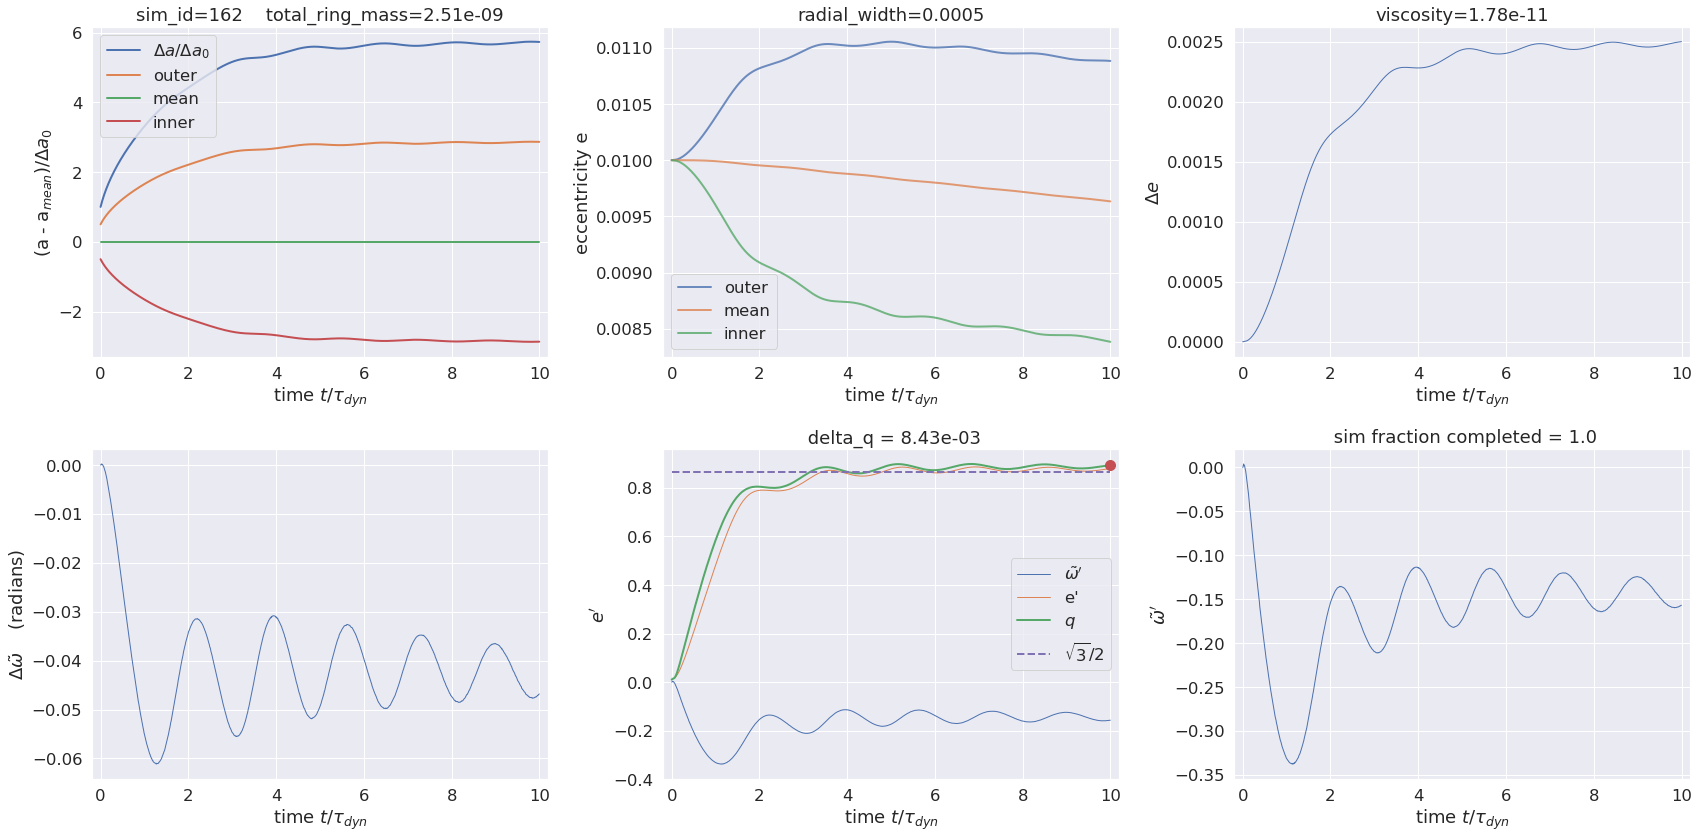

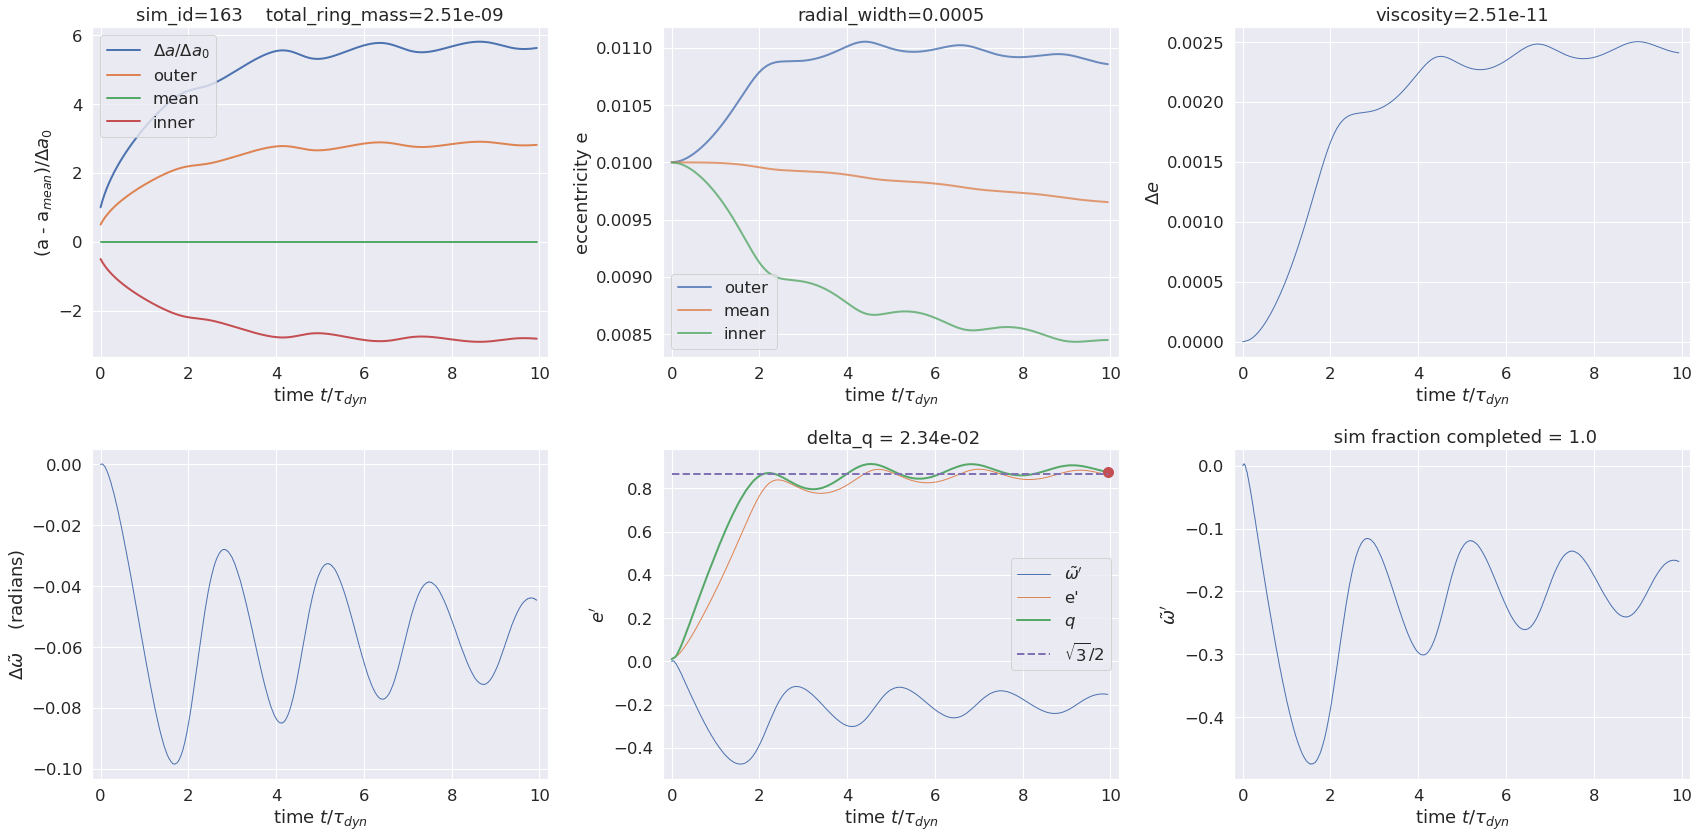

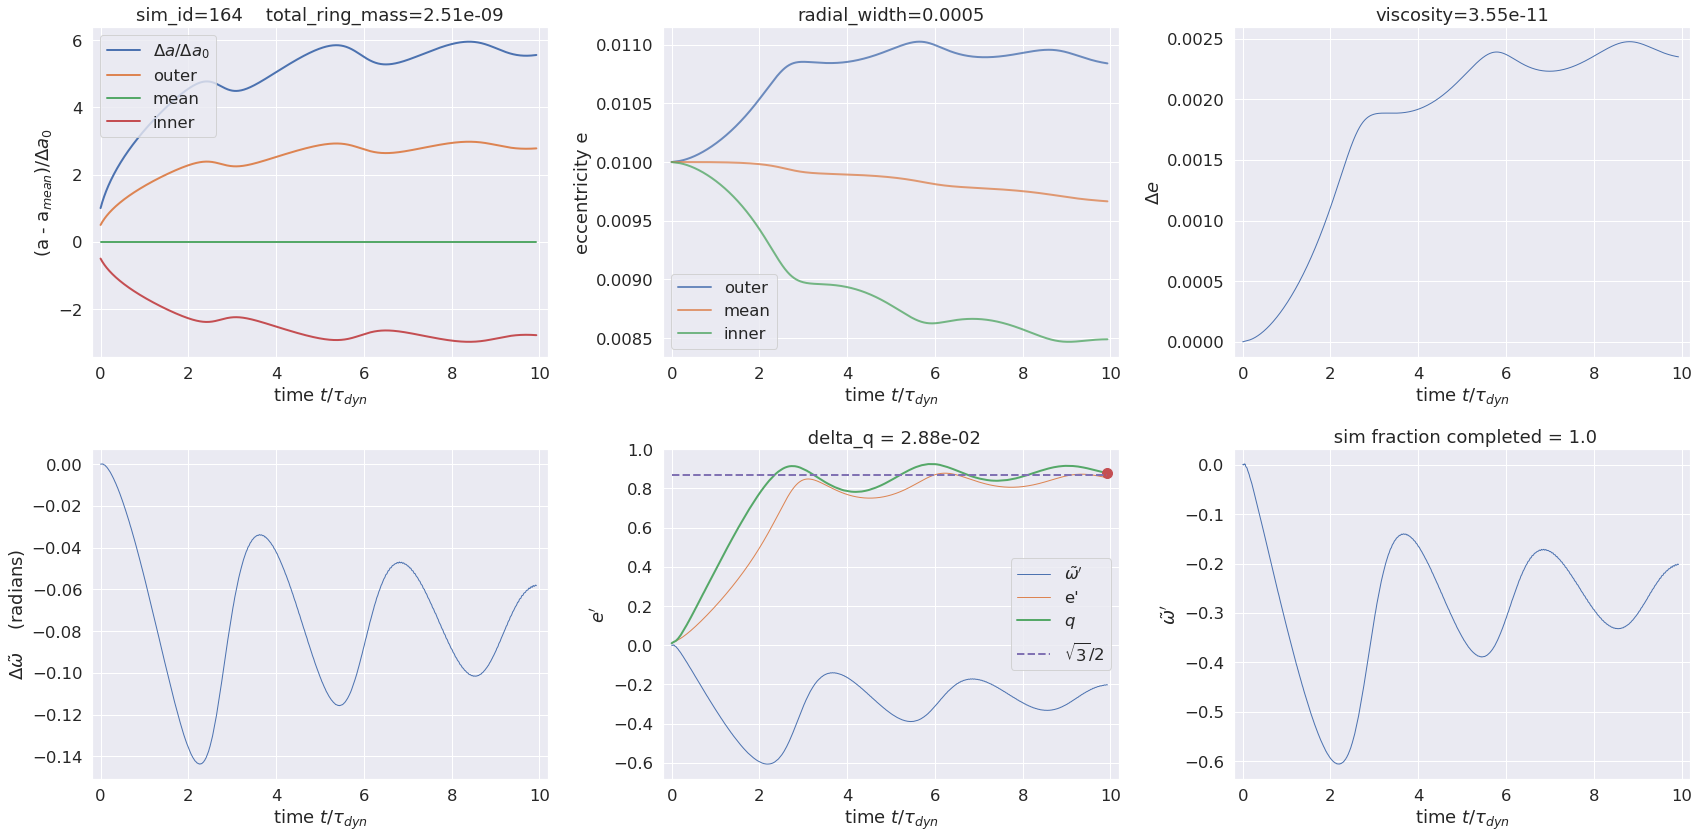

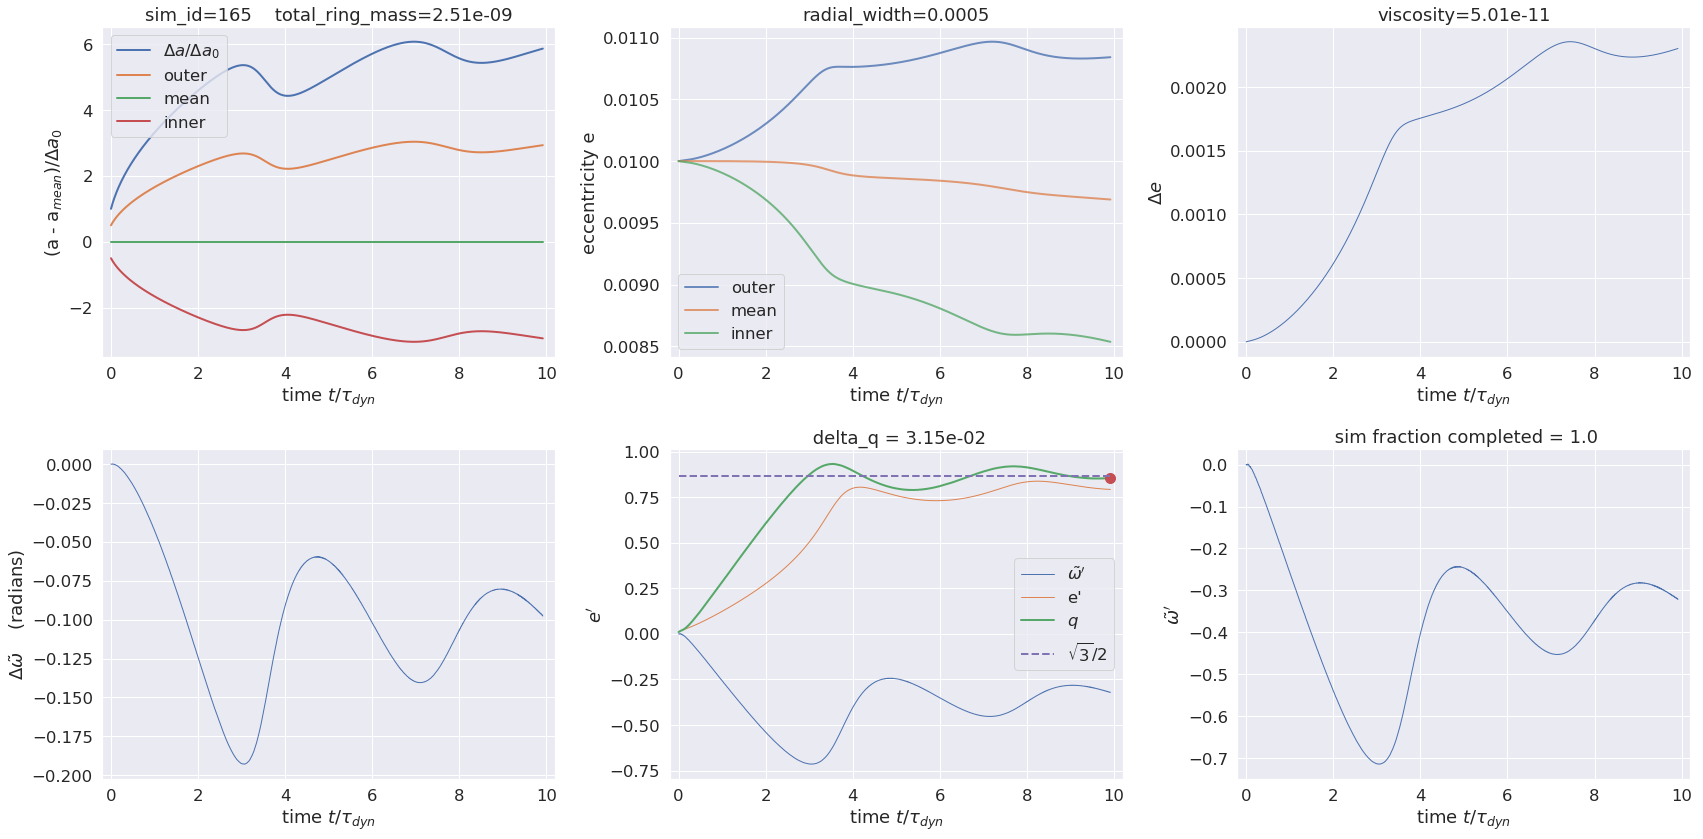

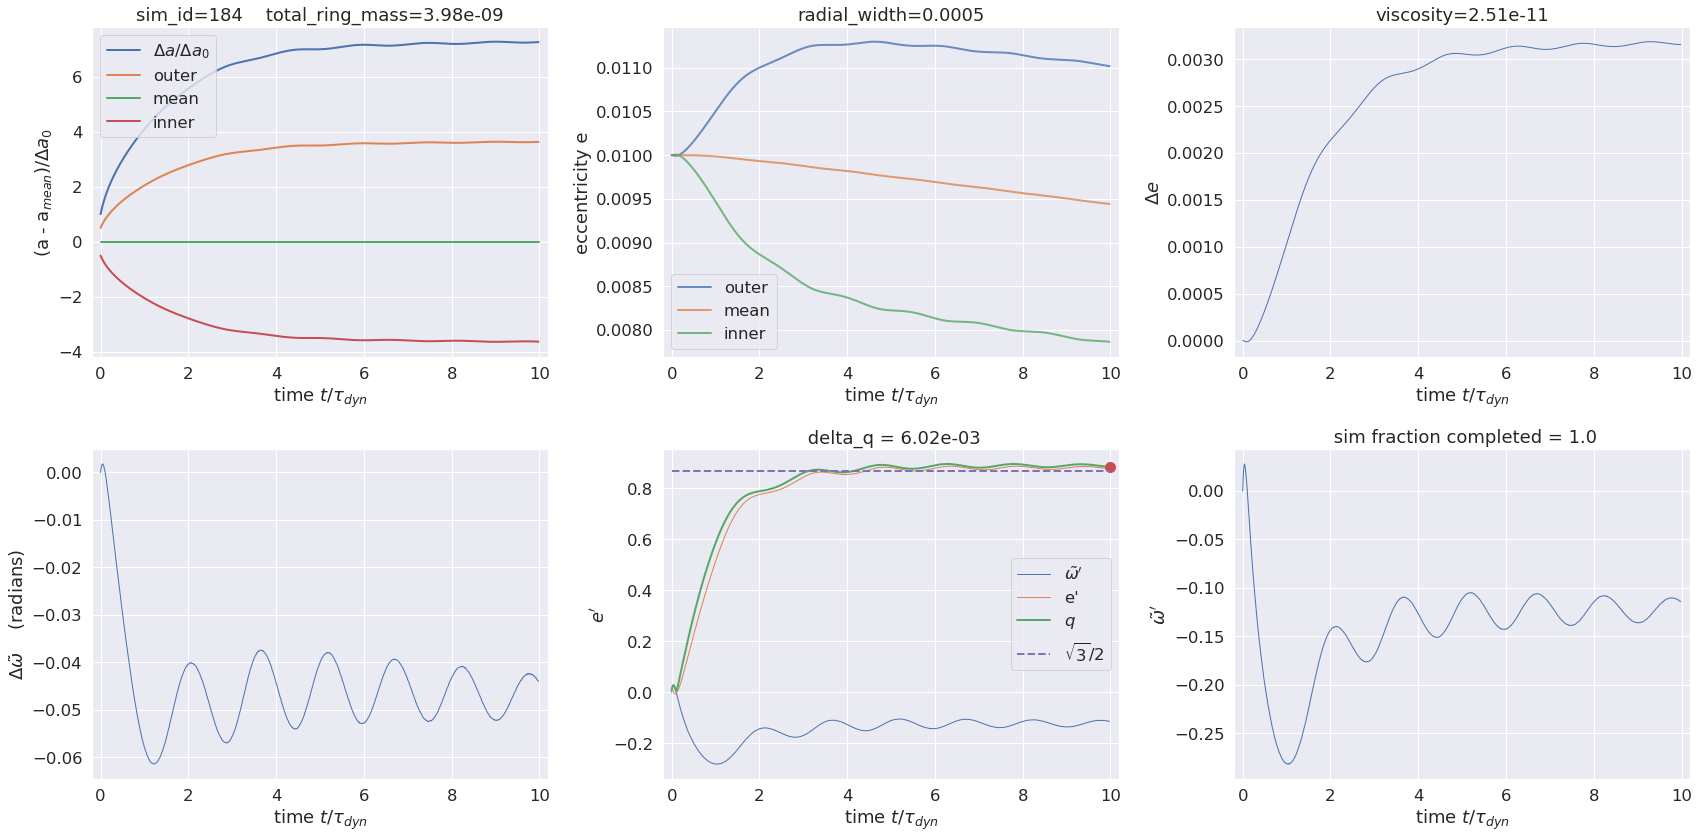

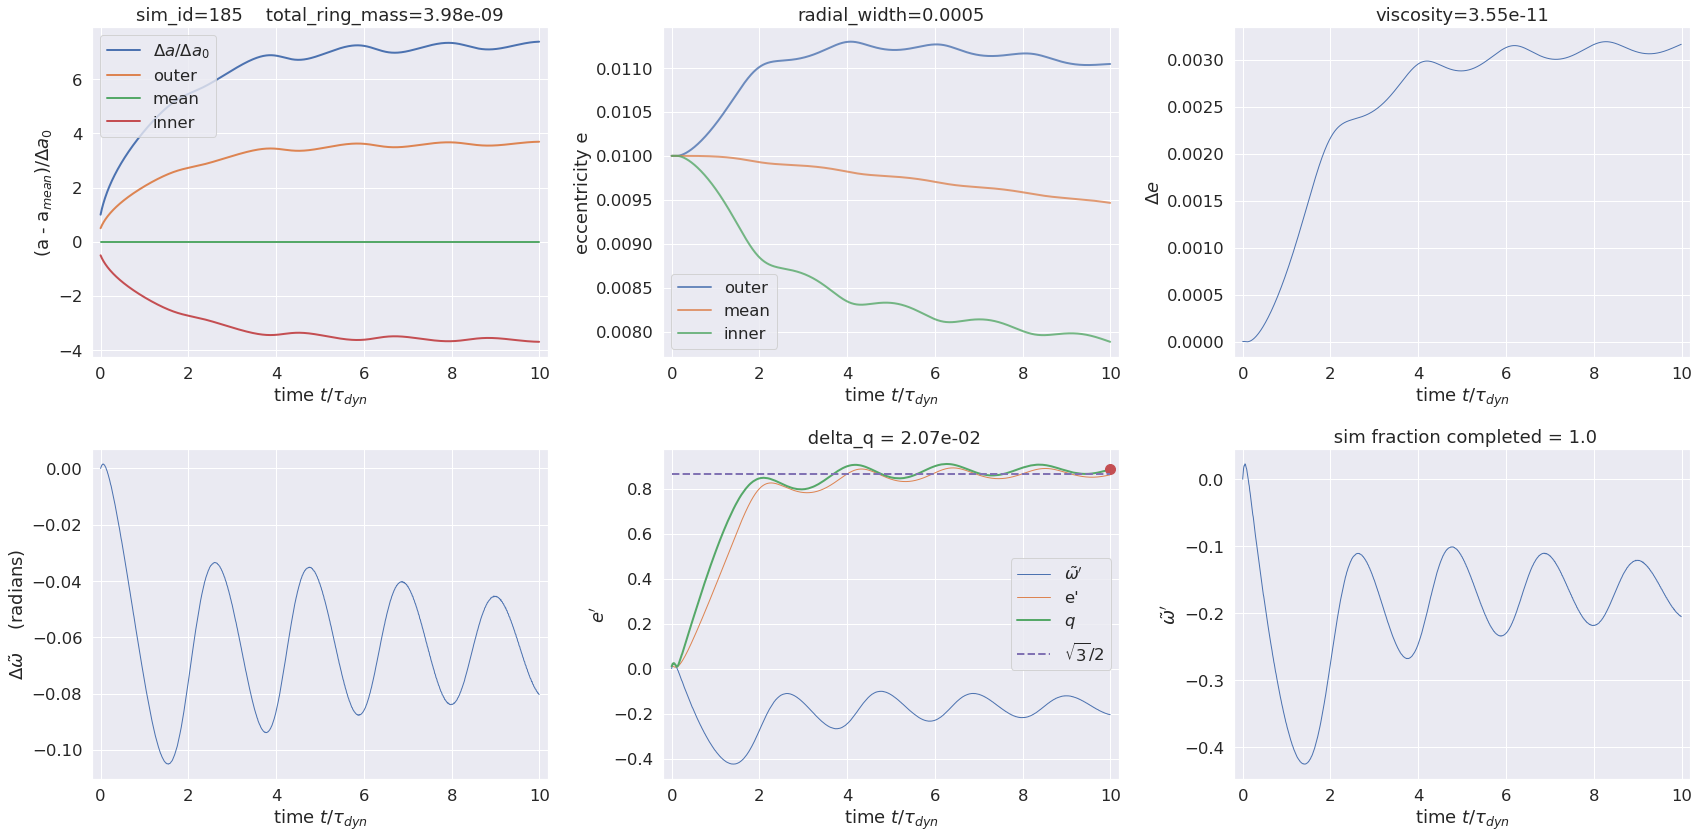

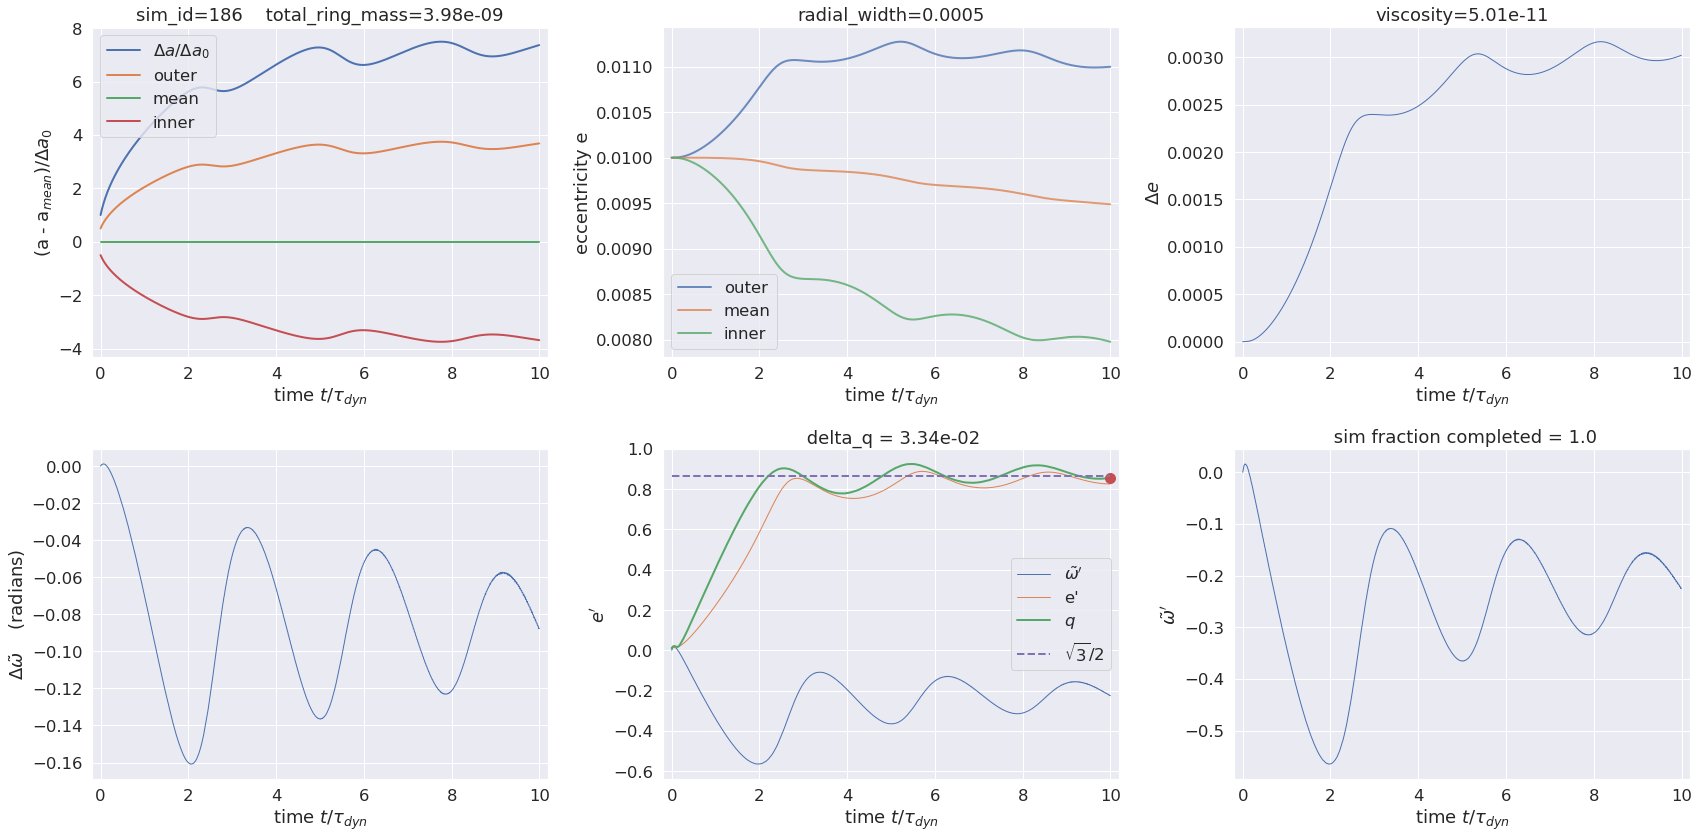

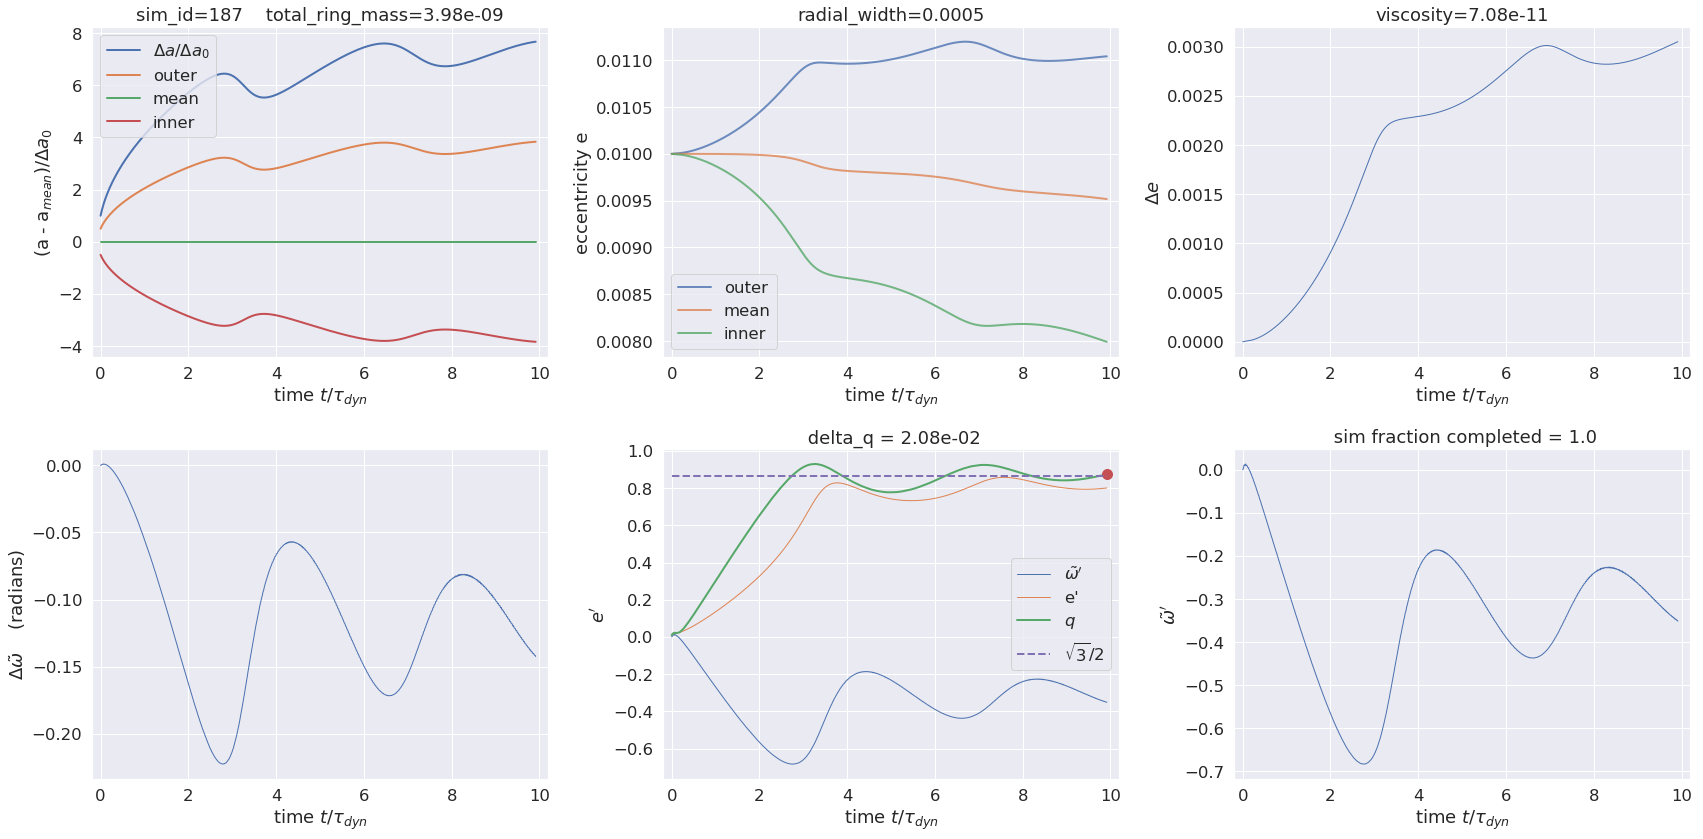

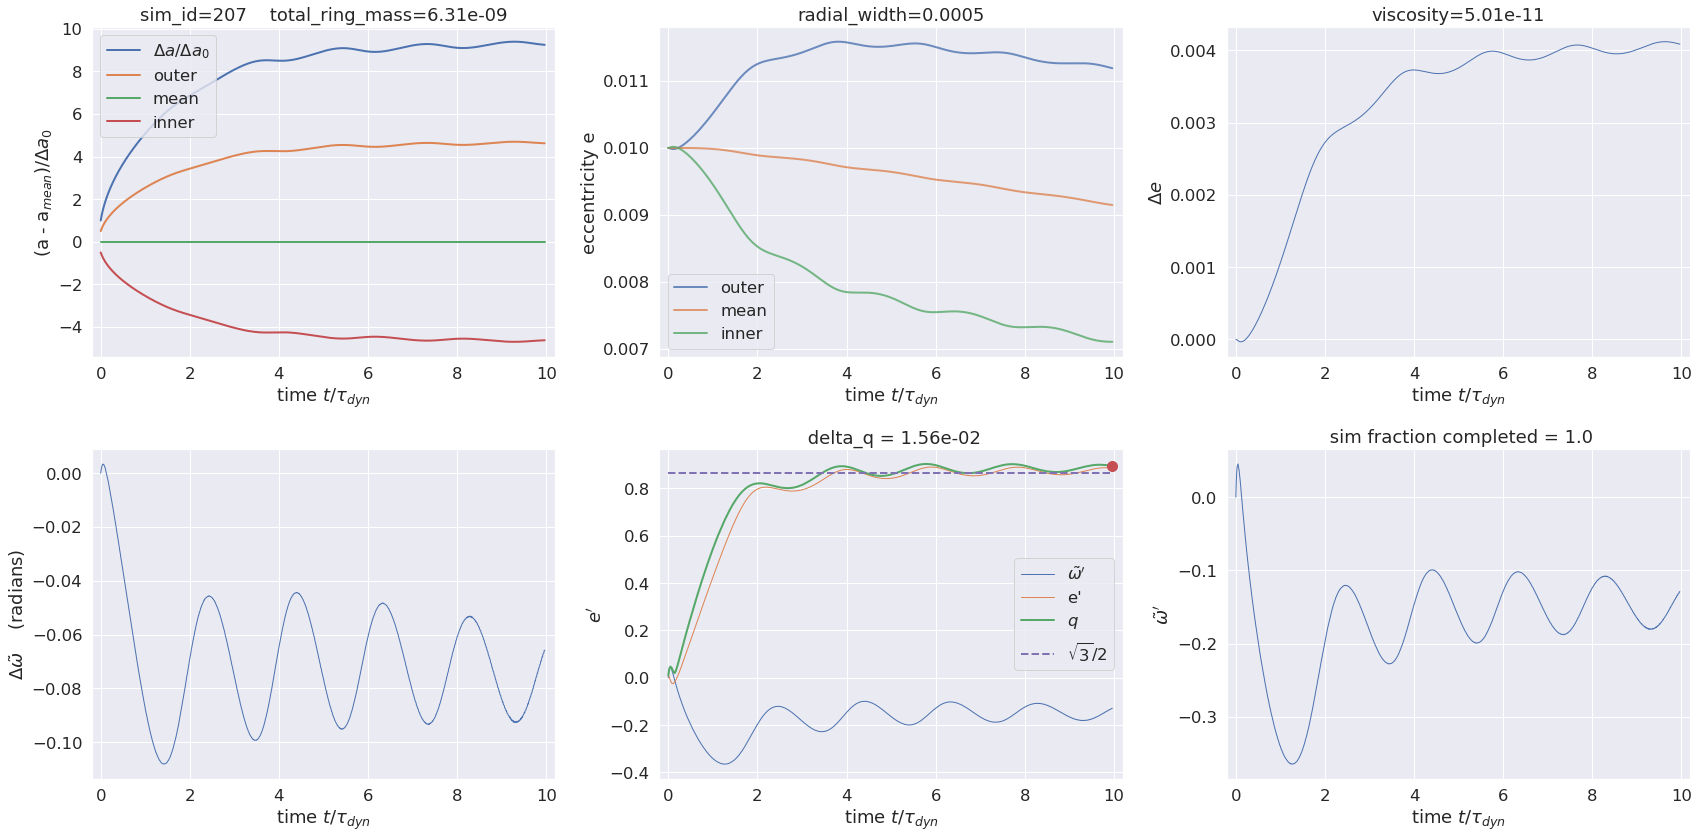

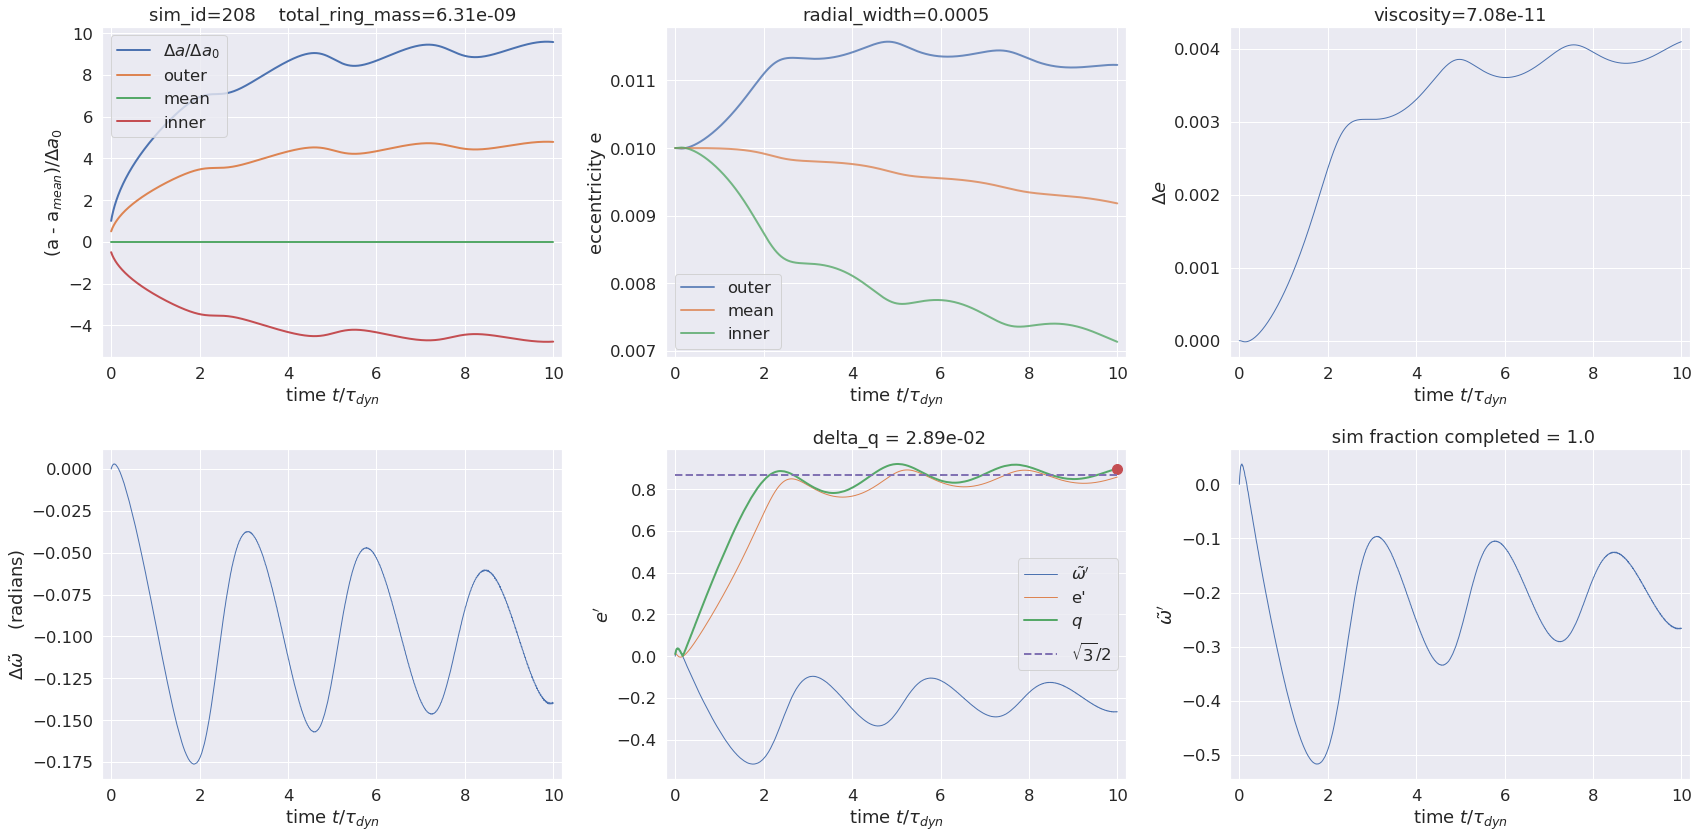

In [6]:
#generate grid of summary plots, for each sim that evolves to completion with low |wt_prime|
debug = False
from helper_fns import *
from libration import *
data = []
xlim = (-0.2, 10.2)
for idx, row in paths_df.iterrows():
    
    #read simulation input and revised output
    execfile('inputs.py')
    path = row.path
    r, t, vr, vt, times, lambda0, monitor = restore_output(path)
    d = {}
    modified_params = monitor['modified_params']
    for key, val in modified_params.iteritems():
        exec(key + '=val')
        d[key] = val
    current_timestep = monitor['current_timestep']
    streamline_crossing_timestep = monitor['streamline_crossing_timestep']
    expected_timestep = timesteps_per_output*total_number_of_outputs
    d['current_timestep'] = current_timestep
    d['streamline_crossing_timestep'] = streamline_crossing_timestep
    d['expected_timestep'] = expected_timestep
    d['path'] = path

    #compute time in units of ringlet's dynamical timescale
    dynamical_timescale = nominal_dynamical_timescale
    dynamical_timescale *= (total_ring_mass/2.0e-09)**mass_power_law
    dynamical_timescale *= (shear_viscosity/1.0e-11)**viscosity_power_law
    dynamical_timescale *= (radial_width/0.0005)**width_power_law
    times_dynamical = times/dynamical_timescale
    d['times_dynamical_max'] = int(times_dynamical.max())
    
    #calculate differences da, de, dwt between outer & inner streamline's periapse
    a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
    a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
        orbit_deltas(times, r, a, e, wt)
    da_init = da[0]
    
    #compute e_prime, wt_prime, q to lowest order, and H(q)
    H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
    idx = (times_dynamical > 0.8*times_dynamical.max())
    d['q'] = q[idx].mean()
    d['delta_q'] = 0.5*(q[idx].max() - q[idx].min())
    d['wt_prime'] = wt_prime[idx].mean()
    
    #report on sims that execute without crossing streamlines
    if ((current_timestep == expected_timestep) and (np.abs(d['wt_prime']) < d['q']/2)):

        if (debug):
            print 'path = ', path
            print 'total_ring_mass = ', total_ring_mass
            print 'radial_width = ', radial_width
            print 'shear_viscosity = ', shear_viscosity
            print 'dynamical_timescale = ', dynamical_timescale
            print 'current, expected timesteps = ', current_timestep, expected_timestep
            print 'execution time (minutes) = ', (monitor['current_time'] - monitor['start_time'])/60.0
        
        #create grid of plots
        sns.set(font_scale=1.5, font='DejaVu Sans')
        fig, axs = plt.subplots(2, 3, figsize=(24, 12))
        
        #plot streamline's mutual a-evolution
        ax = axs[0][0]
        x = times_dynamical
        y = da/da_init
        p = ax.plot(x, y, linestyle='-', linewidth=2, label=r'$\Delta a/\Delta a_0$')
        y = (a_outer - a_mean)/da_init
        p = ax.plot(x, y, linestyle='-', linewidth=2, label='outer')
        y = (a_mean - a_mean)/da_init
        p = ax.plot(x, y, linestyle='-', linewidth=2, label='mean')
        y = (a_inner - a_mean)/da_init
        p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=1, label='inner')
        p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
        p = ax.set_ylabel('(a - a$_{mean})/\Delta a_0$')
        title = 'sim_id=' + str(sim_id) + '    total_ring_mass=' + '{:.2e}'.format(total_ring_mass)
        p = ax.set_title(title)
        p = ax.set_xlim(xlim)
        p = ax.legend()
        p = plt.tight_layout()

        #plot streamline's e-evolution
        ax = axs[0][1]
        x = times_dynamical
        y = e_outer
        p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='outer')
        y = e_mean
        p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='mean')
        y = e_inner
        p = ax.plot(x, y, linestyle='-', linewidth=2, alpha=0.8, label='inner')
        p = ax.set_ylabel('eccentricity e')
        p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
        title = 'radial_width=' + str(radial_width)
        p = ax.set_title(title)
        p = ax.set_xlim(xlim)
        p = ax.legend()
        p = plt.tight_layout()
        
        #plot delta_e versus time
        ax = axs[0][2]
        x = times_dynamical
        y = de
        p = ax.plot(x, y, linestyle='-', linewidth=1)
        p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
        p = ax.set_ylabel(r'$\Delta e$')
        title = 'viscosity=' + '{:.2e}'.format(shear_viscosity)
        p = ax.set_title(title)
        p = ax.set_xlim(xlim)
        p = plt.tight_layout()
        
        #plot dwt versus time
        ax = axs[1][0]
        x = times_dynamical
        y = dwt
        p = ax.plot(x, y, linestyle='-', linewidth=1)
        p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
        p = ax.set_ylabel(r'$\Delta\tilde{\omega}$    (radians)')
        p = ax.set_xlim(xlim)
        p = plt.tight_layout()
        
        #plot e_prime wt_prime and q versus time
        ax = axs[1][1]
        x = times_dynamical
        y = wt_prime
        p = ax.plot(x, y, linestyle='-', linewidth=1, label=r"$\tilde{\omega}'$")
        y = e_prime
        p = ax.plot(x, y, linestyle='-', linewidth=1, label="e'")
        y = q
        p = ax.plot(x, y, linestyle='-', linewidth=2, label=r'$q$')
        if (streamline_crossing_timestep == None):
            p = ax.plot(x[-1], y[-1], marker='o', markersize=10, label='')
        p = ax.plot(x, x*0 + np.sqrt(3.0)/2.0, linestyle='dashed', linewidth=2, label=r"$\sqrt{3}/2$")
        title = ' delta_q = ' + '{:.2e}'.format(d['delta_q'])
        p = ax.set_title(title)
        p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
        p = ax.set_ylabel(r"$e'$")
        p = ax.set_xlim(xlim)
        p = ax.legend()
        p = plt.tight_layout()
        
        #plot wt_prime versus time
        ax = axs[1][2]
        x = times_dynamical
        y = wt_prime
        p = ax.plot(x, y, linestyle='-', linewidth=1)
        title = ' sim fraction completed = ' + str(current_timestep*1.0/expected_timestep)
        p = ax.set_title(title)

        p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
        p = ax.set_ylabel(r"$\tilde{\omega}'$")
        p = ax.set_xlim(xlim)
        p = plt.tight_layout()
    
    data += [d]
df = pd.DataFrame(data)
cols = ['sim_id', 'expected_timestep', 'current_timestep', 'streamline_crossing_timestep', 'times_dynamical_max', 
    'total_ring_mass', 'radial_width', 'shear_viscosity', 'q', 'delta_q', 'wt_prime', 'path']
df = df[cols].sort_values('sim_id').reset_index(drop=True)
df_results = df

In [7]:
#list all sims that evolved into self-confining state
df = df_results
idx = (df.current_timestep == df.expected_timestep)
print 'fraction of sims that execute to completion = ', idx.sum()*1.0/len(idx)
idx = (df.current_timestep == df.expected_timestep) & (df.wt_prime.abs() < df.q/2)
print 'fraction of sims that evolve to self-confining state = ', idx.sum()*1.0/len(idx)
df[idx]

fraction of sims that execute to completion =  0.2510822510822511
fraction of sims that evolve to self-confining state =  0.1341991341991342


sim_id  expected_timestep  current_timestep  \
68       68            1168000           1168000   
69       69             826000            826000   
70       70             585000            585000   
71       71             414000            414000   
72       72             293000            293000   
92       92             656000            656000   
93       93             465000            465000   
94       94             329000            329000   
95       95             233000            233000   
96       96             164000            164000   
115     115             521000            521000   
116     116             369000            369000   
117     117             261000            261000   
118     118             185000            185000   
119     119             131000            131000   
138     138             414000            414000   
139     139             293000            293000   
140     140             207000            207000   
141     141             147000            147000   
142     142             104000            104000   
161     161             329000            329000   
162     162             233000            233000   
163     163             164000            164000   
164     164             116000            116000   
165     165              82000             82000   
184     184             261000            261000   
185     185             185000            185000   
186     186             131000            131000   
187     187              92000             92000   
207     207             207000            207000   
208     208             147000            147000   

     streamline_crossing_timestep  times_dynamical_max  total_ring_mass  \
68                      1116669.0                    9     3.981072e-10   
69                            NaN                    9     3.981072e-10   
70                            NaN                    9     3.981072e-10   
71                            NaN                    9     3.981072e-10   
72                            NaN                    9     3.981072e-10   
92                            NaN                    9     6.309573e-10   
93                            NaN                    9     6.309573e-10   
94                            NaN                    9     6.309573e-10   
95                            NaN                    9     6.309573e-10   
96                            NaN                    9     6.309573e-10   
115                           NaN                    9     1.000000e-09   
116                           NaN                    9     1.000000e-09   
117                           NaN                    9     1.000000e-09   
118                           NaN                    9     1.000000e-09   
119                           NaN                    9     1.000000e-09   
138                           NaN                    9     1.584893e-09   
139                           NaN                    9     1.584893e-09   
140                           NaN                    9     1.584893e-09   
141                           NaN                    9     1.584893e-09   
142                           NaN                    9     1.584893e-09   
161                           NaN                    9     2.511886e-09   
162                           NaN                    9     2.511886e-09   
163                           NaN                    9     2.511886e-09   
164                           NaN                    9     2.511886e-09   
165                           NaN                    9     2.511886e-09   
184                           NaN                    9     3.981072e-09   
185                           NaN                    9     3.981072e-09   
186                           NaN                    9     3.981072e-09   
187                           NaN                    9     3.981072e-09   
207                           NaN                    9     6.309573e-09   
208            

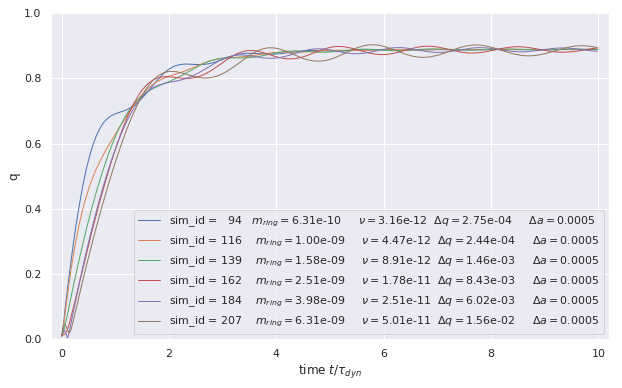

In [9]:
#for selected sim_ids, plot q(t/t_dyn) for the sim whose viscosity yielded lowest delta_q
df = df_results
sim_ids = [94, 116, 139, 162, 184, 207]
xlim = (-0.2, 10.2)
ylim = (0.0, 1.0)
sns.set(font_scale=1.0, font='DejaVu Sans')
f, ax = plt.subplots(figsize=(10, 6))
data = []
for sim_id in sim_ids:
    #for each total_ring_mass, find the sim whose viscosity yields lowest delta_q
    idx = (df.current_timestep == df.expected_timestep) & (df.sim_id == sim_id) & (df.wt_prime.abs() < df.q/2)
    dfs = df[idx]
    try:
        idx = dfs.delta_q.idxmin()
        dfss = dfs.loc[idx]
        path = dfss.path
        sim_id = dfss.sim_id
        delta_q = dfss.delta_q
        #read simulation input and revised output
        execfile('inputs.py')
        r, t, vr, vt, times, lambda0, monitor = restore_output(path)
        modified_params = monitor['modified_params']
        for key, val in modified_params.iteritems():
            exec(key + '=val')
            d[key] = val
        #compute time in units of ringlet's dynamical timescale
        dynamical_timescale = nominal_dynamical_timescale
        dynamical_timescale *= (total_ring_mass/2.0e-09)**mass_power_law
        dynamical_timescale *= (shear_viscosity/1.0e-11)**viscosity_power_law
        dynamical_timescale *= (radial_width/0.0005)**width_power_law
        times_dynamical = times/dynamical_timescale
        #calculate differences da, de, dwt between outer & inner streamline's periapse
        a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
        a_inner, a_outer, a_mean, da, e_inner, e_outer, e_mean, de, wt_inner, wt_outer, dwt = \
            orbit_deltas(times, r, a, e, wt)
        H, q, e_prime, wt_prime = calculate_Hq(a_mean, e_mean, da, de, dwt)
        #plot e_prime wt_prime and q versus time
        x = times_dynamical
        y = q
        sim_id_str = str(sim_id)
        if (len(sim_id_str) < 3): sim_id_str = '  ' + sim_id_str
        label = 'sim_id = ' + sim_id_str
        label += '\t' + r'$m_{ring}=$' + '{:.2e}'.format(total_ring_mass)
        label += '\t' + r'$\nu=$' + '{:.2e}'.format(shear_viscosity)
        label += '\t' + r'$\Delta q=$' + '{:.2e}'.format(delta_q)
        label += '\t' + r'$\Delta a =$' + str(radial_width)
        p = ax.plot(x, y, linestyle='-', linewidth=1, label=label)
        p = ax.set_xlabel(r'time $t/\tau_{dyn}$')
        p = ax.set_ylabel('q')
        p = ax.set_xlim(xlim)
        p = ax.set_ylim(ylim)
        p = ax.legend()
        data += [dfss.to_dict()]
    except:
        pass

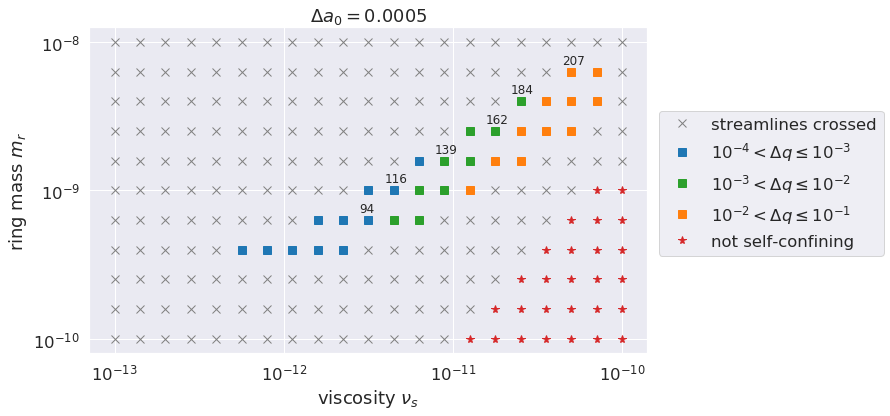

In [10]:
#show grid of simulation outcomes
df = df_results
delta_qs = [(1.0e-4, 1.0e-3, r'$10^{-4}<\Delta q\leq10^{-3}$', color_seq[0]), 
    (1.0e-3, 1.0e-2, r'$10^{-3}<\Delta q\leq10^{-2}$', color_seq[2]), 
    (1.0e-2, 1.0e-1, r'$10^{-2}<\Delta q\leq10^{-1}$', color_seq[1])]
sns.set(font_scale=1.5, font='DejaVu Sans')
f, ax = plt.subplots(figsize=(10, 6))
#indicate sims that didnt complete
idx = (df.current_timestep < df.expected_timestep)
dfs = df[idx]
xp = dfs.shear_viscosity
yp = dfs.total_ring_mass
p = ax.plot(xp, yp, linestyle='none', marker='x', markersize=8, color='grey', label='streamlines crossed')
#self confining sims
idx = (df.current_timestep == df.expected_timestep) & (df.wt_prime.abs() < df.q/2)
dfs = df[idx]
for delta_q_min, delta_q_max, label, color in delta_qs:
    idx = ((dfs.delta_q > delta_q_min) & (dfs.delta_q <= delta_q_max))
    dfss = dfs[idx]
    xp = dfss.shear_viscosity
    yp = dfss.total_ring_mass
    p = ax.plot(xp, yp, linestyle='none', marker='s', markersize=8, label=label, color=color)
#sims that complete but dont self-confine
idx = (df.current_timestep == df.expected_timestep) & (df.wt_prime.abs() > df.q/2)
dfs = df[idx]
xp = dfs.shear_viscosity
yp = dfs.total_ring_mass
color = color_seq[3]
p = ax.plot(xp, yp, linestyle='none', marker='*', markersize=8, color=color, label='not self-confining')
#label sims appearing in above plot
for sim_id in sim_ids:
    idx = (df.sim_id == sim_id)
    dfs = df[idx]
    xp = dfs.shear_viscosity.values[0]
    yp = dfs.total_ring_mass.values[0]
    xy = (0.88*xp, 1.13*yp)
    p = ax.annotate(sim_id, xy, fontsize=12)
p = ax.set_xscale('log')
p = ax.set_yscale('log')
p = ax.set_xlabel(r'viscosity $\nu_s$')
p = ax.set_ylabel(r'ring mass $m_r$')
radial_width = str(df.radial_width.max())
title = r'$\Delta a_0 = $' + str(radial_width)
p = ax.set_title(title)
p = ax.legend(loc=(1.02, 0.3))

In [11]:
df = df_results
print 'total_ring_mass = ', df.total_ring_mass.unique()
print 'radial_width = ', df.radial_width.unique()
print 'shear_viscosity = ', df.shear_viscosity.unique()

total_ring_mass =  [1.00000000e-10 1.58489319e-10 2.51188643e-10 3.98107171e-10
 6.30957344e-10 1.00000000e-09 1.58489319e-09 2.51188643e-09
 3.98107171e-09 6.30957344e-09 1.00000000e-08]
radial_width =  [0.0005]
shear_viscosity =  [1.00000000e-13 1.41253754e-13 1.99526231e-13 2.81838293e-13
 3.98107171e-13 5.62341325e-13 7.94328235e-13 1.12201845e-12
 1.58489319e-12 2.23872114e-12 3.16227766e-12 4.46683592e-12
 6.30957344e-12 8.91250938e-12 1.25892541e-11 1.77827941e-11
 2.51188643e-11 3.54813389e-11 5.01187234e-11 7.07945784e-11
 1.00000000e-10]
